# Enrichment of regulons from Regulons_by_strain

In [16]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)
    
import warnings

import pandas as pd
from IPython.display import display
pd.set_option('max_colwidth', 70)
pd.set_option('display.max_rows', 500)
import string
import numpy as np
import matplotlib.pyplot as plt

from orangecontrib.bioinformatics.geneset.__init__ import list_all

import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from functionsDENet import loadPickle, savePickle
import stages_DE.enrichment_library as enr
reload(enr)
import stages_DE.enrichment_library as enr

In [2]:
#Path for expression data (mergedGenes_RPKUM.tsv)
dataPath='/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
#Path for regulons
pathRegulons='/home/karin/Documents/timeTrajectories/data/regulons/by_strain/kN300_mean0std1_log/'

## Used gene sets
Use gene sets that do not have less than 5 or more than 500 genes. Use all ontologies.

In [3]:
# Get all gene sets
gene_sets=list(list_all(organism='44689'))
GENE_SETS_ONTOLOGY=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=True,set_sizes=(5,500))

In [4]:
# Find out max/min gene set sizes and N sets
max_n=0
min_n=np.inf
for k,v in GENE_SETS_ONTOLOGY.items():
    for s in v:
        n=len(s.genes)
        if n<min_n:
            min_n=n
        if n>max_n:
            max_n=n
print('Min size',min_n,'Max size',max_n)  
print('N sets',{k:len(v) for k,v in GENE_SETS_ONTOLOGY.items()})

Min size 5 Max size 440
N sets {('KEGG', 'Pathways'): 96, ('GO', 'cellular_component'): 24, ('GO', 'biological_process'): 52, ('GO', 'molecular_function'): 35, ('Dictybase', 'Phenotypes'): 209}


In [5]:
# For conversion of gene names to EID
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
all_gene_names= genes[(genes != 0).any(axis=1)].index
NAME_EID=enr.name_genes_entrez(gene_names=all_gene_names, key_entrez=False)
ALL_GENE_NAMES_EID=enr.convert_EID(genes=all_gene_names, name_EID=NAME_EID)

In [17]:
def group_diff_enrichment(data:pd.DataFrame,group:str,padj:float=0.25,min_overlap:int=None,
                          use_annotated_genes:bool=False,enrichment_map=False):
    #Displays only gene sets that have overlap with query greater or equal to min_overlap 
    #For p value and padj calculation uses alll that have overlap >=1 } from gene_set_enrichment
    """
    :param use_annotated_genes: if True use for reference and query  only genes that have at 
    least one gene set annotation
    """
    selected=list(data[data['Cluster']==group].index)
    query_EID=enr.convert_EID(genes=selected, name_EID=NAME_EID)
    print('***  '+group+' selected:',len(selected),'with EID:',len(query_EID))
    
    reference_gene_eids=ALL_GENE_NAMES_EID.copy()
    query_eids=query_EID.copy()
    
    if use_annotated_genes:
        gene_sets_genes=set()
        for gene_set_name, gene_sets in GENE_SETS_ONTOLOGY.items():
            for gene_set in gene_sets:
                gene_sets_genes.update(gene_set.genes)
        reference_gene_eids=set(reference_gene_eids) & gene_sets_genes
        query_eids=set(query_eids) & gene_sets_genes
        print('Ratio of genes annotated with a gene set in reference',
              round(len(reference_gene_eids)/len(ALL_GENE_NAMES_EID),2),
             'and query',round(len(query_eids)/len(query_EID),2))
    
    query_in_enriched=set()
    result=None
    fig,ax=None,None
    if len(query_eids) > 0:
        enrichment=enr.gene_set_enrichment(query_eids, reference_EID=reference_gene_eids, 
                                                padj_threshold=padj,min_overlap=min_overlap,
                                                gene_sets_ontology=GENE_SETS_ONTOLOGY)
        if len(enrichment)>0:
            enrichment_display=list()
            enrichment= sorted(enrichment, key=lambda data: data.padj)
            for enriched in enrichment:
                query_in_enriched.update(enriched.gene_set.genes & query_eids)
                enrichment_display.append({'Gene set':enriched.gene_set.name,
                                           'Ontology':enriched.ontology[0]+': '+enriched.ontology[1],
                                           'FDR':"{:.2e}".format(enriched.padj),'N in query':enriched.in_query,
                                           'Set size':len(enriched.gene_set.genes),
                                                          'N in ref.':enriched.in_reference})
            result=pd.DataFrame(enrichment_display)
            if enrichment_map:
                fig,ax=plt.subplots(figsize=(10,10))
                with warnings.catch_warnings(record=True):
                    enr.enrichment_map(enriched=enrichment, ax=ax,query_size=len(query_eids),
                                   fontsize=8,min_overlap=0.1)
                fig.suptitle('Group '+group+' using '+str(len(query_eids))+' out of '+str(len(selected))+
                             ' genes for enrichment calculation.')
    print('Enrichment at FDR: '+str(padj)+' and min query - gene set overlap',str(min_overlap))
    print('N query genes in displayed gene sets:',len(query_in_enriched),'out of', len(query_eids),
          'query genes used for enrichment calculation.')
    display(result)
    print('\n')
    if enrichment_map:
        return (result,(fig,ax))
    else:
        return result

## Enrichment reports

Enrichment map: Circles show gene sets (as displayed in the report). Size shows the overlap between gene set and query (genes of interest) as ratio of query genes used in enrichemnt calculation (larger is more). Colour denotes padj value (smaller is more yellow), with all values below 10^-10 being assigned the same shade of yellow. Lines show overlap between gene sets as ration of genes from smaller gene set present in the larger one, encoded as line thickness. Overlaps below 0.1 were excludded from plotting. Arrows show that all genes of a samller gene set (arrow start) are contained in the larger gene set. 

In [7]:
save_enrichment=False

### Enrichment for expression_minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30.pdf

In [65]:
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30.tab',index_col=0)
for group in range(1,len(regulons['Cluster'].unique())+1):
    enriched=group_diff_enrichment(data=regulons,group='C'+str(group),min_overlap=2)
    if save_enrichment and enriched is not None:
        enriched.to_csv(pathRegulons+'enrichment/minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30_enrichment_cluster'+str(group)+'.tsv', sep='\t',index=False)

***  C1 selected: 30 with EID: 30
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 20 out of 30 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Ribosome biogenesis in eukaryotes,KEGG: Pathways,3.61e-19,12,72,68
1,nucleolus,GO: cellular_component,4.81e-17,11,72,72
2,ribosome biogenesis,GO: biological_process,5.97e-16,10,61,61
3,ribonucleoprotein complex assembly,GO: biological_process,3.39e-07,4,18,18
4,RNA binding,GO: molecular_function,8.74e-06,6,169,169
5,protein-containing complex assembly,GO: biological_process,7.59e-04,4,134,133
6,rRNA binding,GO: molecular_function,1.00e-03,2,13,13
7,cellular component assembly,GO: biological_process,2.69e-03,4,202,201
8,helicase activity,GO: molecular_function,1.20e-02,2,51,51
9,methyltransferase activity,GO: molecular_function,1.30e-02,2,58,56




***  C2 selected: 66 with EID: 65
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 34 out of 65 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Oxidative phosphorylation,KEGG: Pathways,6.60e-10,9,71,54
1,mitochondrion,GO: cellular_component,1.23e-04,9,229,229
2,Citrate cycle (TCA cycle),KEGG: Pathways,4.91e-04,4,30,30
3,Phagosome,KEGG: Pathways,3.34e-03,4,53,52
4,protein folding,GO: biological_process,1.16e-02,3,37,37
5,generation of precursor metabolites and energy,GO: biological_process,1.16e-02,4,77,77
6,cytoplasmic vesicle,GO: cellular_component,1.16e-02,6,211,211
7,aberrant cellular response to stress,Dictybase: Phenotypes,1.55e-02,2,11,11
8,Ribosome,KEGG: Pathways,1.59e-02,4,105,97
9,Biosynthesis of secondary metabolites,KEGG: Pathways,3.01e-02,6,289,281




***  C3 selected: 68 with EID: 68
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 62 out of 68 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Ribosome,KEGG: Pathways,6.41e-126,60,105,97
1,ribosome,GO: cellular_component,1.47e-124,59,93,93
2,structural constituent of ribosome,GO: molecular_function,8.17e-109,53,85,85
3,structural molecule activity,GO: molecular_function,1.72e-98,53,117,117
4,translation,GO: biological_process,1.79e-85,52,169,169
5,RNA binding,GO: molecular_function,3.26e-15,16,169,169
6,rRNA binding,GO: molecular_function,8.86e-13,7,13,13
7,cytosol,GO: cellular_component,6.12e-05,8,203,203
8,ribosome biogenesis,GO: biological_process,1.68e-02,3,61,61
9,delayed development,Dictybase: Phenotypes,1.83e-01,2,69,69




***  C4 selected: 55 with EID: 55
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 21 out of 55 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cytoskeletal protein binding,GO: molecular_function,6.19e-08,10,158,158
1,Endocytosis,KEGG: Pathways,3.88e-04,5,77,75
2,protein-containing complex assembly,GO: biological_process,1.98e-03,5,134,133
3,cellular component assembly,GO: biological_process,1.98e-03,6,202,201
4,cytoskeleton organization,GO: biological_process,1.98e-03,6,197,196
5,plasma membrane,GO: cellular_component,1.98e-03,7,268,268
6,response to stress,GO: biological_process,5.56e-03,7,360,358
7,cytoskeleton,GO: cellular_component,6.63e-03,5,185,185
8,cytosol,GO: cellular_component,5.47e-02,4,203,203
9,cytoplasmic vesicle,GO: cellular_component,5.60e-02,4,211,211




***  C5 selected: 41 with EID: 41
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 38 out of 41 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Proteasome,KEGG: Pathways,2.56e-69,29,39,37
1,peptidase activity,GO: molecular_function,6.88e-34,21,91,91
2,catabolic process,GO: biological_process,1.46e-31,25,250,250
3,enzyme regulator activity,GO: molecular_function,5.17e-02,3,105,105
4,response to stress,GO: biological_process,5.21e-02,5,360,358
5,ATPase activity,GO: molecular_function,1.06e-01,3,169,168
6,Protein processing in endoplasmic reticulum,KEGG: Pathways,1.64e-01,2,91,88




***  C6 selected: 74 with EID: 74
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 24 out of 74 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,anatomical structure development,GO: biological_process,3.88e-06,15,440,438
1,cell adhesion,GO: biological_process,7.03e-03,5,84,83
2,development arrests at loose mound stage,Dictybase: Phenotypes,7.53e-03,3,20,20
3,extracellular region,GO: cellular_component,9.01e-03,6,157,157
4,Glycosaminoglycan degradation,KEGG: Pathways,1.08e-02,2,6,6
5,decreased fruiting body size,Dictybase: Phenotypes,1.31e-02,4,76,75
6,decreased aggregate size,Dictybase: Phenotypes,1.31e-02,3,32,32
7,increased slug migration,Dictybase: Phenotypes,1.31e-02,2,8,8
8,signal transduction,GO: biological_process,1.31e-02,8,352,350
9,response to stress,GO: biological_process,1.36e-02,8,360,358




***  C7 selected: 40 with EID: 40
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 13 out of 40 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,aberrant CRAC localization to the plasma membrane,Dictybase: Phenotypes,1.28e-02,2,6,6
1,development arrests at tipped mound stage,Dictybase: Phenotypes,1.39e-02,2,12,12
2,translucent sorus,Dictybase: Phenotypes,1.39e-02,2,9,9
3,decreased intracellular cAMP level,Dictybase: Phenotypes,1.39e-02,2,12,12
4,anatomical structure formation involved in morphogenesis,GO: biological_process,2.93e-02,3,74,74
5,cell death,GO: biological_process,3.52e-02,2,25,25
6,anatomical structure development,GO: biological_process,3.52e-02,6,440,438
7,kinase activity,GO: molecular_function,4.09e-02,5,328,327
8,aberrant aggregation,Dictybase: Phenotypes,6.48e-02,2,61,61
9,decreased chemotaxis to cAMP,Dictybase: Phenotypes,6.48e-02,2,63,63




***  C8 selected: 23 with EID: 23
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 3 out of 23 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,kinase activity,GO: molecular_function,1.10e-01,3,328,327




***  C9 selected: 20 with EID: 20
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 0 out of 20 query genes used for enrichment calculation.


None



***  C10 selected: 36 with EID: 36
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 18 out of 36 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell cycle,GO: biological_process,1.86e-14,13,167,167
1,chromosome segregation,GO: biological_process,1.19e-10,6,18,18
2,mitotic nuclear division,GO: biological_process,5.12e-09,5,15,15
3,mitotic cell cycle,GO: biological_process,1.05e-07,7,100,100
4,cell division,GO: biological_process,1.95e-07,7,115,115
5,DNA replication,KEGG: Pathways,1.95e-07,5,34,33
6,chromosome,GO: cellular_component,2.15e-07,6,70,70
7,chromosome organization,GO: biological_process,2.64e-07,6,74,74
8,cytoskeleton,GO: cellular_component,3.22e-06,7,185,185
9,cytoskeleton organization,GO: biological_process,8.01e-04,5,197,196




***  C11 selected: 77 with EID: 77
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 10 out of 77 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell differentiation,GO: biological_process,2.43e-03,7,145,145
1,decreased sporulation,Dictybase: Phenotypes,2.39e-01,2,53,53
2,development arrests at mound stage,Dictybase: Phenotypes,2.39e-01,2,56,54
3,anatomical structure development,GO: biological_process,2.39e-01,7,440,438
4,cell adhesion,GO: biological_process,2.39e-01,3,84,83
5,Starch and sucrose metabolism,KEGG: Pathways,2.39e-01,2,31,31




***  C12 selected: 57 with EID: 57
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 9 out of 57 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,3.15e-04,7,157,157
1,cell-cell signaling,GO: biological_process,5.19e-02,2,16,16
2,decreased spore viability,Dictybase: Phenotypes,2.28e-01,2,60,59
3,peptidase activity,GO: molecular_function,2.37e-01,2,91,91




***  C13 selected: 64 with EID: 64
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 2 out of 64 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,aberrant cell-cell adhesion,Dictybase: Phenotypes,3.67e-03,2,5,5




***  C14 selected: 19 with EID: 19
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 0 out of 19 query genes used for enrichment calculation.


None



***  C15 selected: 91 with EID: 91
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 30 out of 91 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,external encapsulating structure,GO: cellular_component,7.69e-11,7,13,13
1,cell wall,GO: cellular_component,7.69e-11,7,13,13
2,aberrant spore coat morphology,Dictybase: Phenotypes,4.01e-09,6,12,12
3,anatomical structure formation involved in morphogenesis,GO: biological_process,7.97e-08,9,74,74
4,cell wall organization or biogenesis,GO: biological_process,1.10e-06,5,15,15
5,cell differentiation,GO: biological_process,1.73e-06,10,145,145
6,anatomical structure development,GO: biological_process,2.59e-04,13,440,438
7,Starch and sucrose metabolism,KEGG: Pathways,9.26e-04,4,31,31
8,abolished stalk cell differentiation,Dictybase: Phenotypes,1.09e-02,2,7,7
9,extracellular region,GO: cellular_component,1.09e-02,6,157,157




***  C16 selected: 74 with EID: 74
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 8 out of 74 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,1.40e-04,8,157,157




***  C17 selected: 61 with EID: 59
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 0 out of 59 query genes used for enrichment calculation.


None



***  C18 selected: 46 with EID: 45
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 10 out of 45 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,4.59e-04,6,157,157
1,anatomical structure formation involved in morphogenesis,GO: biological_process,2.70e-02,3,74,74
2,cell differentiation,GO: biological_process,1.15e-01,3,145,145
3,oxidoreductase activity,GO: molecular_function,1.46e-01,3,210,207




***  C19 selected: 58 with EID: 58
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 9 out of 58 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell adhesion,GO: biological_process,8.68e-02,3,84,83
1,extracellular region,GO: cellular_component,8.68e-02,4,157,157
2,hydrolase activity,GO: molecular_function,1.57e-01,2,46,45
3,cell differentiation,GO: biological_process,1.92e-01,3,145,145
4,anatomical structure formation involved in morphogenesis,GO: biological_process,1.96e-01,2,74,74




***  C20 selected: 54 with EID: 54
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 4 out of 54 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,decreased spore viability,Dictybase: Phenotypes,2.34e-01,2,60,59
1,Phagosome,KEGG: Pathways,2.34e-01,2,53,52




***  C21 selected: 45 with EID: 45
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 0 out of 45 query genes used for enrichment calculation.


None

#### Using only genes annotated with at least one gene set 
To find genes that have gene set annotations only gene sets used in enrichment are used (see above). Genes that are in at least one of these gene sets are used for enrichment calculation, both for reference and gene group of interest (query).

***  C1 selected: 30 with EID: 30
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 20 out of 30 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Ribosome biogenesis in eukaryotes,KEGG: Pathways,3.61e-19,12,72,68
1,nucleolus,GO: cellular_component,4.81e-17,11,72,72
2,ribosome biogenesis,GO: biological_process,5.97e-16,10,61,61
3,ribonucleoprotein complex assembly,GO: biological_process,3.39e-07,4,18,18
4,RNA binding,GO: molecular_function,8.74e-06,6,169,169
5,protein-containing complex assembly,GO: biological_process,7.59e-04,4,134,133
6,rRNA binding,GO: molecular_function,1.00e-03,2,13,13
7,cellular component assembly,GO: biological_process,2.69e-03,4,202,201
8,helicase activity,GO: molecular_function,1.20e-02,2,51,51
9,methyltransferase activity,GO: molecular_function,1.30e-02,2,58,56




***  C2 selected: 66 with EID: 65
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 34 out of 65 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Oxidative phosphorylation,KEGG: Pathways,6.60e-10,9,71,54
1,mitochondrion,GO: cellular_component,1.23e-04,9,229,229
2,Citrate cycle (TCA cycle),KEGG: Pathways,4.91e-04,4,30,30
3,Phagosome,KEGG: Pathways,3.34e-03,4,53,52
4,cytoplasmic vesicle,GO: cellular_component,1.16e-02,6,211,211
5,protein folding,GO: biological_process,1.16e-02,3,37,37
6,generation of precursor metabolites and energy,GO: biological_process,1.16e-02,4,77,77
7,aberrant cellular response to stress,Dictybase: Phenotypes,1.55e-02,2,11,11
8,Ribosome,KEGG: Pathways,1.59e-02,4,105,97
9,Biosynthesis of secondary metabolites,KEGG: Pathways,3.01e-02,6,289,281




***  C3 selected: 68 with EID: 68
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 62 out of 68 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Ribosome,KEGG: Pathways,6.41e-126,60,105,97
1,ribosome,GO: cellular_component,1.47e-124,59,93,93
2,structural constituent of ribosome,GO: molecular_function,8.17e-109,53,85,85
3,structural molecule activity,GO: molecular_function,1.72e-98,53,117,117
4,translation,GO: biological_process,1.79e-85,52,169,169
5,RNA binding,GO: molecular_function,3.26e-15,16,169,169
6,rRNA binding,GO: molecular_function,8.86e-13,7,13,13
7,cytosol,GO: cellular_component,6.12e-05,8,203,203
8,ribosome biogenesis,GO: biological_process,1.68e-02,3,61,61
9,delayed development,Dictybase: Phenotypes,1.83e-01,2,69,69




***  C4 selected: 55 with EID: 55
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 21 out of 55 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cytoskeletal protein binding,GO: molecular_function,6.19e-08,10,158,158
1,Endocytosis,KEGG: Pathways,3.88e-04,5,77,75
2,plasma membrane,GO: cellular_component,1.98e-03,7,268,268
3,cellular component assembly,GO: biological_process,1.98e-03,6,202,201
4,cytoskeleton organization,GO: biological_process,1.98e-03,6,197,196
5,protein-containing complex assembly,GO: biological_process,1.98e-03,5,134,133
6,response to stress,GO: biological_process,5.56e-03,7,360,358
7,cytoskeleton,GO: cellular_component,6.63e-03,5,185,185
8,cytosol,GO: cellular_component,5.47e-02,4,203,203
9,cytoplasmic vesicle,GO: cellular_component,5.60e-02,4,211,211




***  C5 selected: 41 with EID: 41
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 38 out of 41 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Proteasome,KEGG: Pathways,2.56e-69,29,39,37
1,peptidase activity,GO: molecular_function,6.88e-34,21,91,91
2,catabolic process,GO: biological_process,1.46e-31,25,250,250
3,enzyme regulator activity,GO: molecular_function,5.17e-02,3,105,105
4,response to stress,GO: biological_process,5.21e-02,5,360,358
5,ATPase activity,GO: molecular_function,1.06e-01,3,169,168
6,Protein processing in endoplasmic reticulum,KEGG: Pathways,1.64e-01,2,91,88




***  C6 selected: 74 with EID: 74
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 24 out of 74 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,anatomical structure development,GO: biological_process,3.88e-06,15,440,438
1,cell adhesion,GO: biological_process,7.03e-03,5,84,83
2,development arrests at loose mound stage,Dictybase: Phenotypes,7.53e-03,3,20,20
3,extracellular region,GO: cellular_component,9.01e-03,6,157,157
4,Glycosaminoglycan degradation,KEGG: Pathways,1.08e-02,2,6,6
5,signal transduction,GO: biological_process,1.31e-02,8,352,350
6,decreased aggregate size,Dictybase: Phenotypes,1.31e-02,3,32,32
7,increased slug migration,Dictybase: Phenotypes,1.31e-02,2,8,8
8,decreased fruiting body size,Dictybase: Phenotypes,1.31e-02,4,76,75
9,response to stress,GO: biological_process,1.36e-02,8,360,358




***  C7 selected: 40 with EID: 40
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 13 out of 40 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,aberrant CRAC localization to the plasma membrane,Dictybase: Phenotypes,1.28e-02,2,6,6
1,translucent sorus,Dictybase: Phenotypes,1.39e-02,2,9,9
2,development arrests at tipped mound stage,Dictybase: Phenotypes,1.39e-02,2,12,12
3,decreased intracellular cAMP level,Dictybase: Phenotypes,1.39e-02,2,12,12
4,anatomical structure formation involved in morphogenesis,GO: biological_process,2.93e-02,3,74,74
5,cell death,GO: biological_process,3.52e-02,2,25,25
6,anatomical structure development,GO: biological_process,3.52e-02,6,440,438
7,kinase activity,GO: molecular_function,4.09e-02,5,328,327
8,RNA degradation,KEGG: Pathways,6.48e-02,2,48,48
9,cell differentiation,GO: biological_process,6.48e-02,3,145,145




***  C8 selected: 23 with EID: 23
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 3 out of 23 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,kinase activity,GO: molecular_function,1.10e-01,3,328,327




***  C9 selected: 20 with EID: 20
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 0 out of 20 query genes used for enrichment calculation.


None



***  C10 selected: 36 with EID: 36
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 18 out of 36 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell cycle,GO: biological_process,1.86e-14,13,167,167
1,chromosome segregation,GO: biological_process,1.19e-10,6,18,18
2,mitotic nuclear division,GO: biological_process,5.12e-09,5,15,15
3,mitotic cell cycle,GO: biological_process,1.05e-07,7,100,100
4,DNA replication,KEGG: Pathways,1.95e-07,5,34,33
5,cell division,GO: biological_process,1.95e-07,7,115,115
6,chromosome,GO: cellular_component,2.15e-07,6,70,70
7,chromosome organization,GO: biological_process,2.64e-07,6,74,74
8,cytoskeleton,GO: cellular_component,3.22e-06,7,185,185
9,cytoskeleton organization,GO: biological_process,8.01e-04,5,197,196




***  C11 selected: 77 with EID: 77
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 10 out of 77 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell differentiation,GO: biological_process,2.43e-03,7,145,145
1,Starch and sucrose metabolism,KEGG: Pathways,2.39e-01,2,31,31
2,cell adhesion,GO: biological_process,2.39e-01,3,84,83
3,anatomical structure development,GO: biological_process,2.39e-01,7,440,438
4,decreased sporulation,Dictybase: Phenotypes,2.39e-01,2,53,53
5,development arrests at mound stage,Dictybase: Phenotypes,2.39e-01,2,56,54




***  C12 selected: 57 with EID: 57
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 9 out of 57 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,3.15e-04,7,157,157
1,cell-cell signaling,GO: biological_process,5.19e-02,2,16,16
2,decreased spore viability,Dictybase: Phenotypes,2.28e-01,2,60,59
3,peptidase activity,GO: molecular_function,2.37e-01,2,91,91




***  C13 selected: 64 with EID: 64
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 2 out of 64 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,aberrant cell-cell adhesion,Dictybase: Phenotypes,3.67e-03,2,5,5




***  C14 selected: 19 with EID: 19
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 0 out of 19 query genes used for enrichment calculation.


None



***  C15 selected: 91 with EID: 91
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 30 out of 91 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell wall,GO: cellular_component,7.69e-11,7,13,13
1,external encapsulating structure,GO: cellular_component,7.69e-11,7,13,13
2,aberrant spore coat morphology,Dictybase: Phenotypes,4.01e-09,6,12,12
3,anatomical structure formation involved in morphogenesis,GO: biological_process,7.97e-08,9,74,74
4,cell wall organization or biogenesis,GO: biological_process,1.10e-06,5,15,15
5,cell differentiation,GO: biological_process,1.73e-06,10,145,145
6,anatomical structure development,GO: biological_process,2.59e-04,13,440,438
7,Starch and sucrose metabolism,KEGG: Pathways,9.26e-04,4,31,31
8,extracellular region,GO: cellular_component,1.09e-02,6,157,157
9,abolished stalk cell differentiation,Dictybase: Phenotypes,1.09e-02,2,7,7




***  C16 selected: 74 with EID: 74
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 8 out of 74 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,1.40e-04,8,157,157




***  C17 selected: 61 with EID: 59
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 0 out of 59 query genes used for enrichment calculation.


None



***  C18 selected: 46 with EID: 45
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 10 out of 45 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,4.59e-04,6,157,157
1,anatomical structure formation involved in morphogenesis,GO: biological_process,2.70e-02,3,74,74
2,cell differentiation,GO: biological_process,1.15e-01,3,145,145
3,oxidoreductase activity,GO: molecular_function,1.46e-01,3,210,207




***  C19 selected: 58 with EID: 58
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 9 out of 58 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,8.68e-02,4,157,157
1,cell adhesion,GO: biological_process,8.68e-02,3,84,83
2,hydrolase activity,GO: molecular_function,1.57e-01,2,46,45
3,cell differentiation,GO: biological_process,1.92e-01,3,145,145
4,anatomical structure formation involved in morphogenesis,GO: biological_process,1.96e-01,2,74,74




***  C20 selected: 54 with EID: 54
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 4 out of 54 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Phagosome,KEGG: Pathways,2.34e-01,2,53,52
1,decreased spore viability,Dictybase: Phenotypes,2.34e-01,2,60,59




***  C21 selected: 45 with EID: 45
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 0 out of 45 query genes used for enrichment calculation.


None

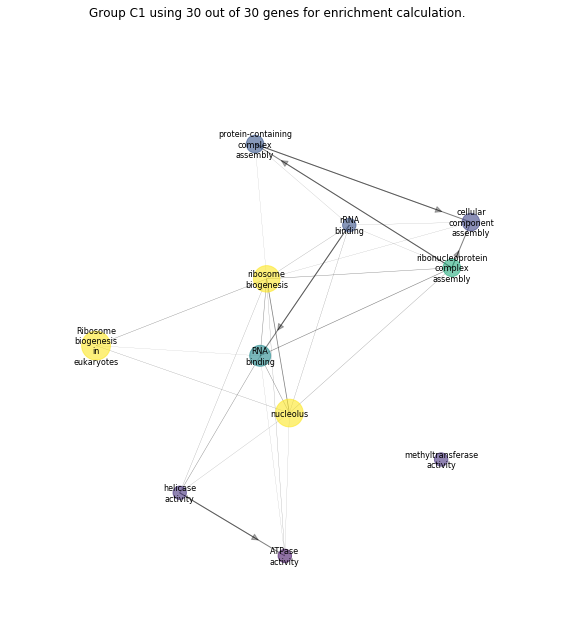

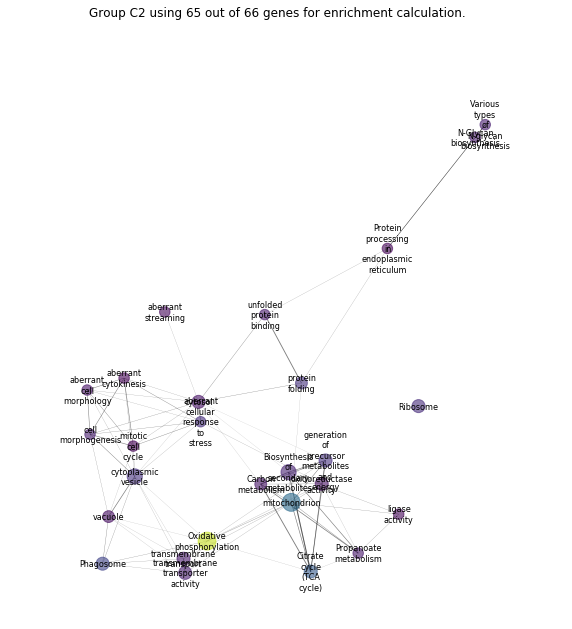

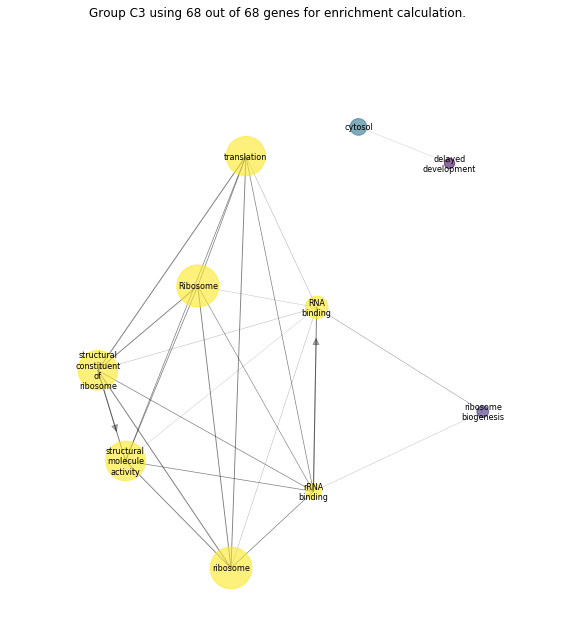

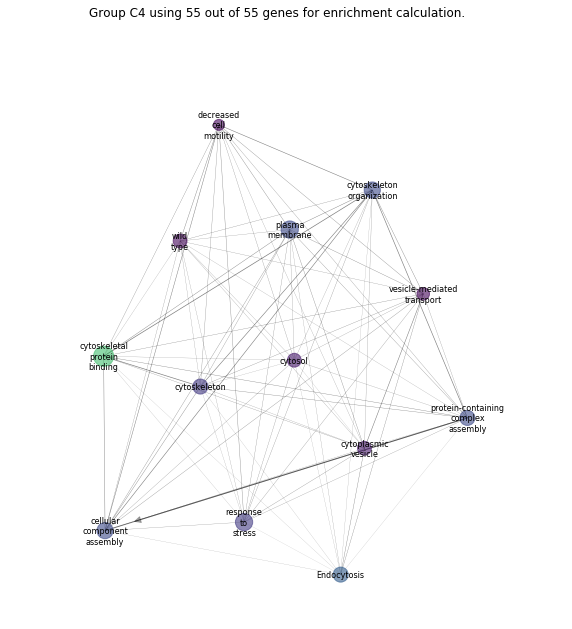

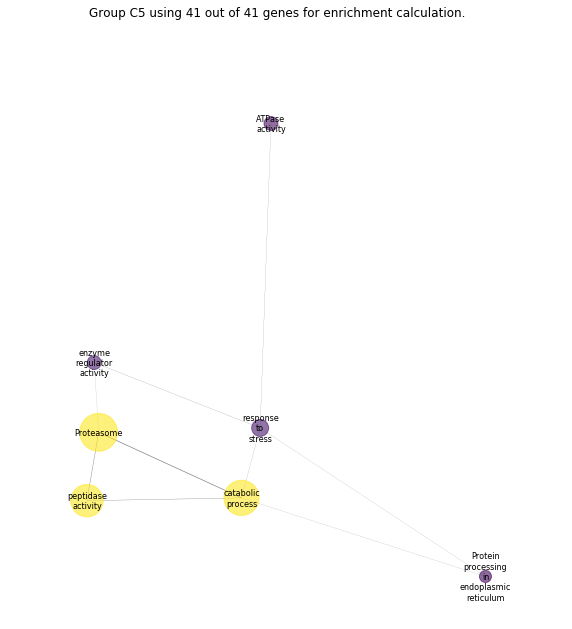

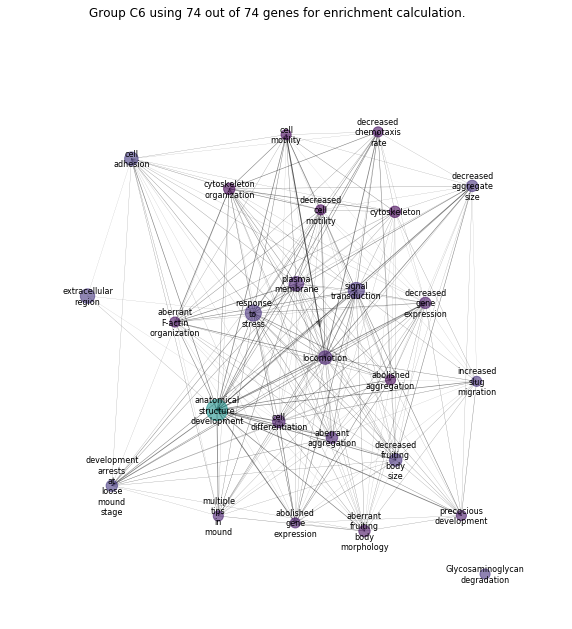

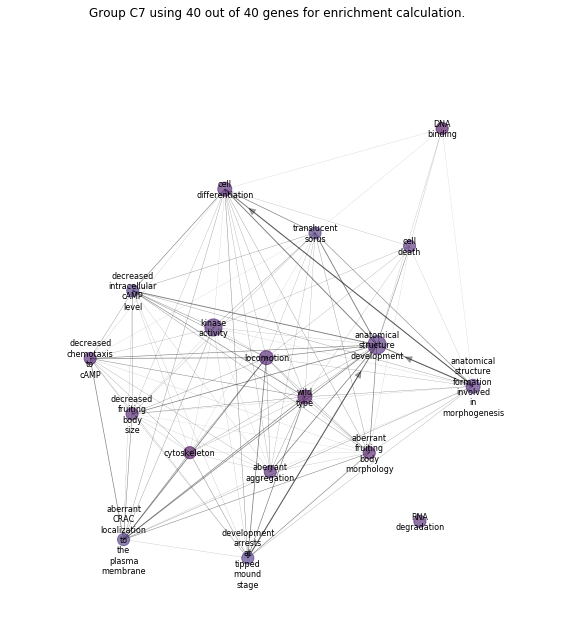

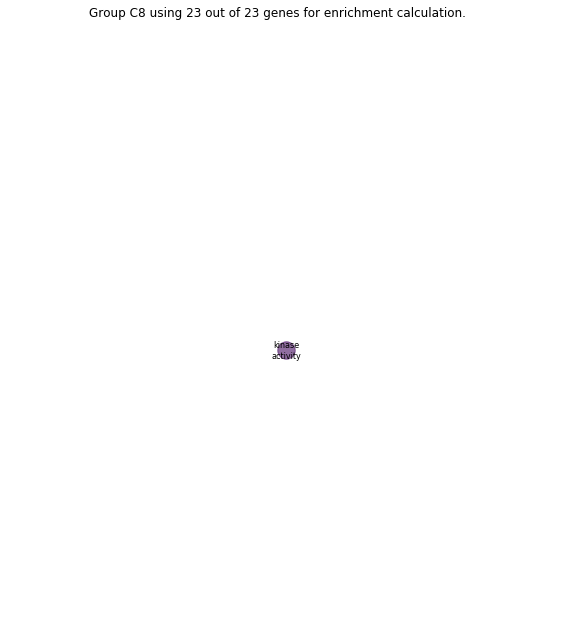

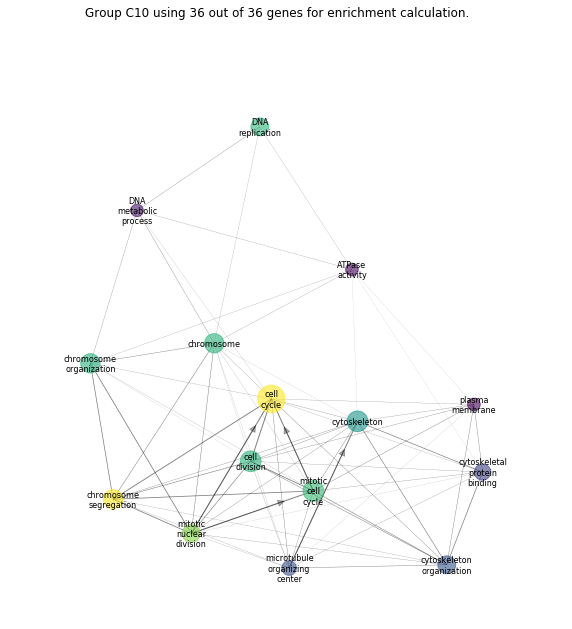

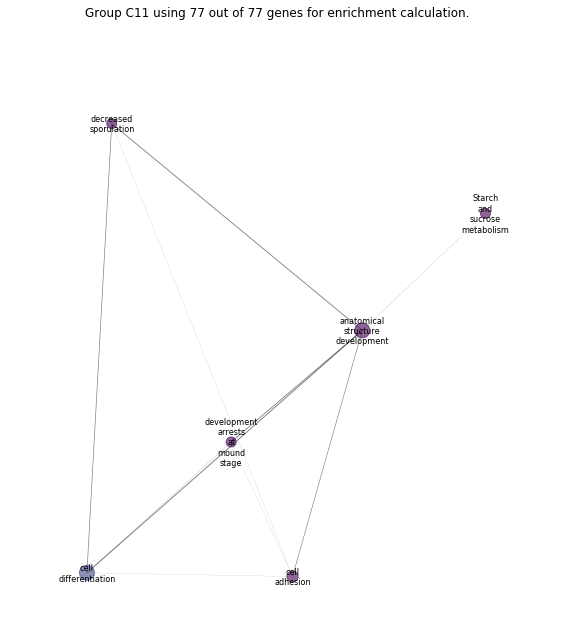

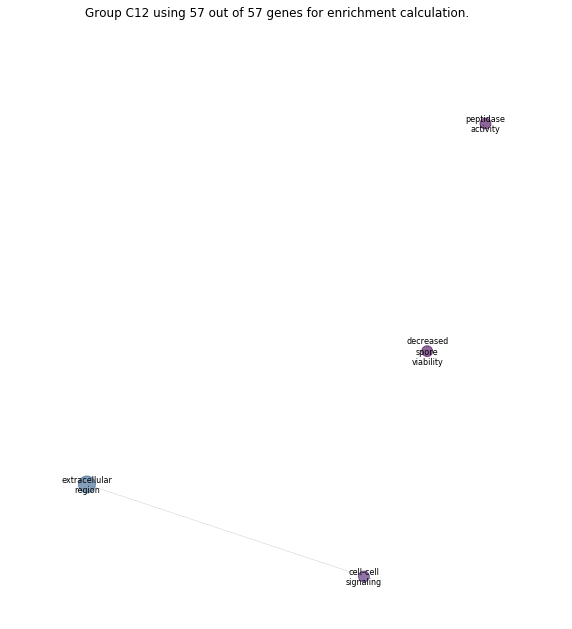

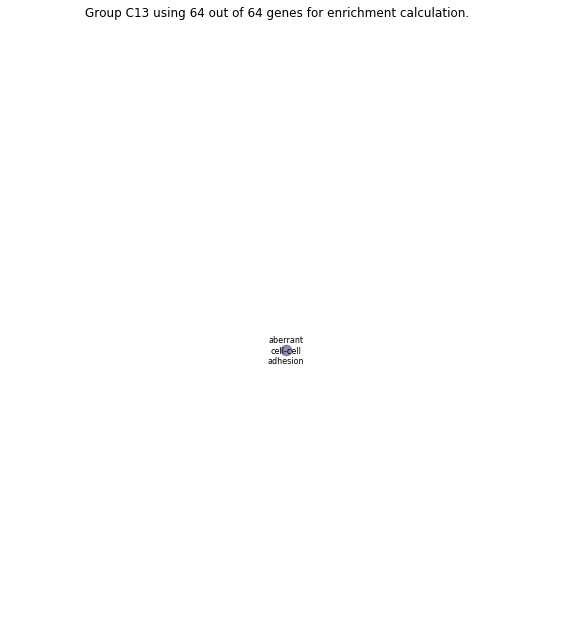

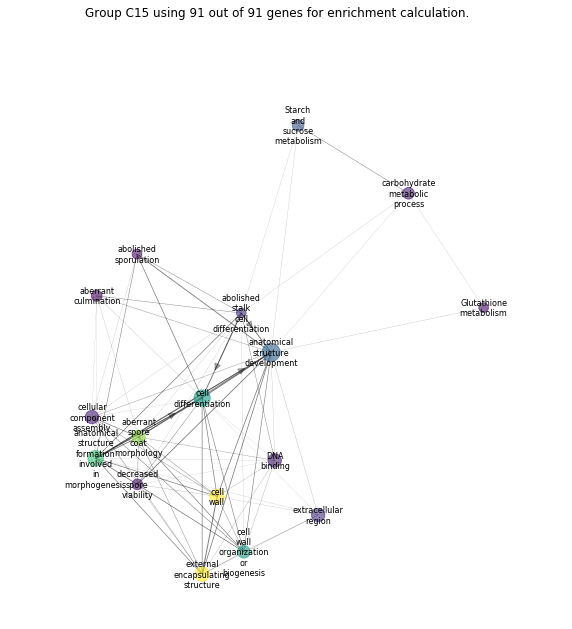

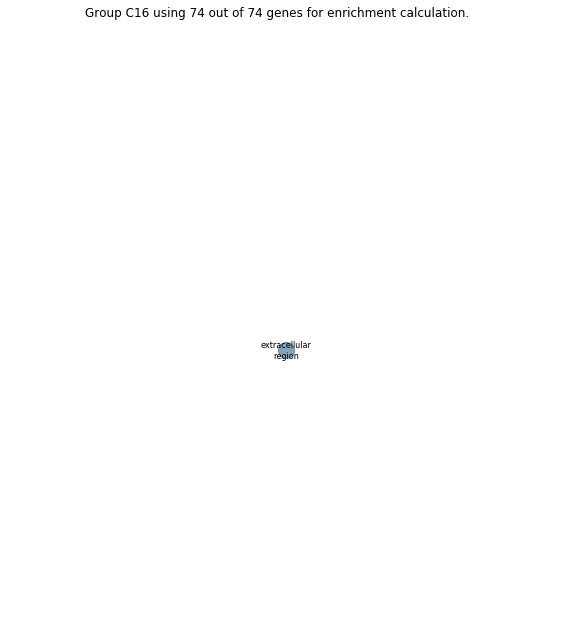

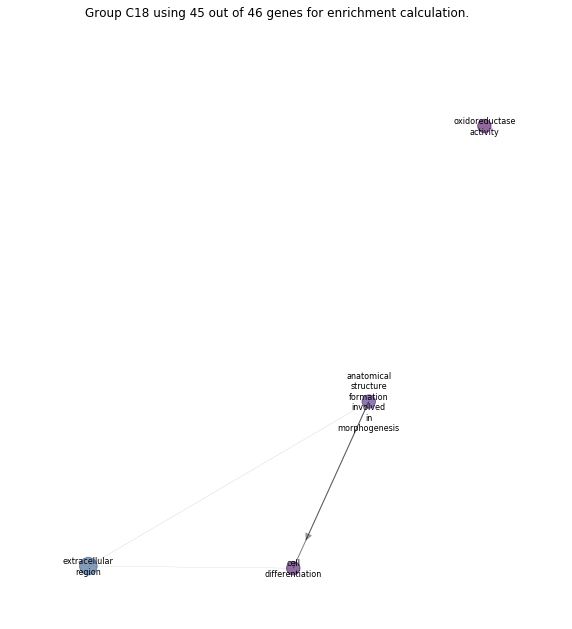

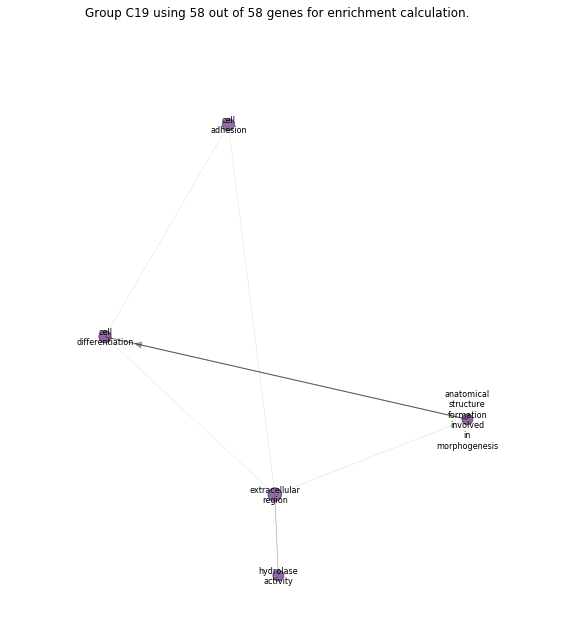

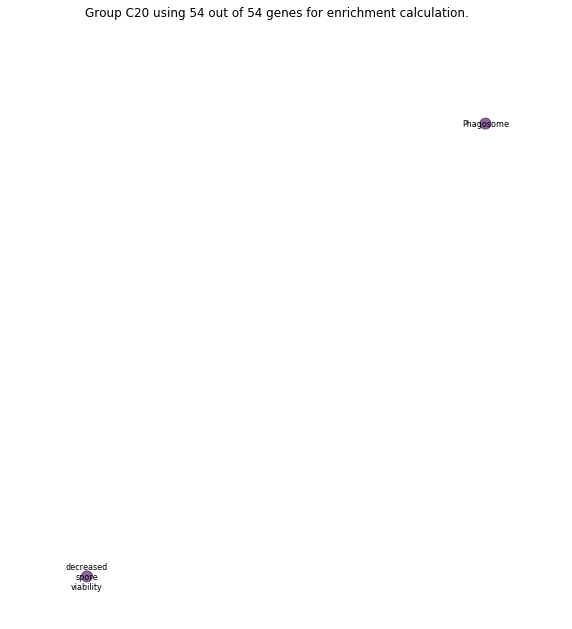

In [18]:
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30.tab',index_col=0)
for group in range(1,len(regulons['Cluster'].unique())+1):
    enriched=group_diff_enrichment(data=regulons,group='C'+str(group),min_overlap=2,enrichment_map=True)
    if  save_enrichment and enriched is not None:
        enriched.to_csv(pathRegulons+'enrichment/minExpressed0.990.1Strains1Min1Max18_clustersLouvain0.4minmaxNologPCA30kN30_annotatedOnly_enrichment_cluster'+str(group)+'.tsv', sep='\t',index=False)

### Enrichment for mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab

*** Cluster C1 (A)
***  C1 selected: 31 with EID: 31
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 20 out of 31 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Ribosome biogenesis in eukaryotes,KEGG: Pathways,7.70e-19,12,72,68
1,nucleolus,GO: cellular_component,9.74e-17,11,72,72
2,ribosome biogenesis,GO: biological_process,1.15e-15,10,61,61
3,ribonucleoprotein complex assembly,GO: biological_process,5.11e-07,4,18,18
4,RNA binding,GO: molecular_function,1.41e-05,6,169,169
5,protein-containing complex assembly,GO: biological_process,1.13e-03,4,134,133
6,rRNA binding,GO: molecular_function,1.41e-03,2,13,13
7,cellular component assembly,GO: biological_process,4.00e-03,4,202,201
8,helicase activity,GO: molecular_function,1.68e-02,2,51,51
9,methyltransferase activity,GO: molecular_function,1.82e-02,2,58,56




*** Cluster C2 (B)
***  C2 selected: 54 with EID: 54
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 25 out of 54 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Oxidative phosphorylation,KEGG: Pathways,7.89e-08,7,71,54
1,mitochondrion,GO: cellular_component,7.89e-08,11,229,229
2,generation of precursor metabolites and energy,GO: biological_process,1.55e-05,6,77,77
3,protein folding,GO: biological_process,2.28e-04,4,37,37
4,unfolded protein binding,GO: molecular_function,2.02e-03,3,27,27
5,oxidoreductase activity,GO: molecular_function,2.14e-03,6,210,207
6,Phagosome,KEGG: Pathways,1.01e-02,3,53,52
7,Ribosome,KEGG: Pathways,4.11e-02,3,105,97
8,Citrate cycle (TCA cycle),KEGG: Pathways,4.11e-02,2,30,30
9,Propanoate metabolism,KEGG: Pathways,4.11e-02,2,32,32




*** Cluster C3 (C)
***  C3 selected: 54 with EID: 54
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 44 out of 54 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Ribosome,KEGG: Pathways,1.07e-86,44,105,97
1,ribosome,GO: cellular_component,4.46e-85,43,93,93
2,structural constituent of ribosome,GO: molecular_function,8.18e-76,39,85,85
3,structural molecule activity,GO: molecular_function,4.04e-69,39,117,117
4,translation,GO: biological_process,5.72e-62,39,169,169
5,RNA binding,GO: molecular_function,4.40e-10,11,169,169
6,rRNA binding,GO: molecular_function,6.50e-07,4,13,13




*** Cluster C4 (D)
***  C4 selected: 43 with EID: 43
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 21 out of 43 query genes used for enrichment calculation.


/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/pygraphviz/agraph.py:1367: RuntimeWarning: Warning: Overlap value "prism" unsupported - ignored

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cytoskeletal protein binding,GO: molecular_function,2.38e-10,11,158,158
1,cellular component assembly,GO: biological_process,5.27e-06,8,202,201
2,cytoskeleton organization,GO: biological_process,5.27e-06,8,197,196
3,protein-containing complex assembly,GO: biological_process,5.27e-06,7,134,133
4,plasma membrane,GO: cellular_component,3.07e-05,8,268,268
5,cytoskeleton,GO: cellular_component,3.07e-05,7,185,185
6,Endocytosis,KEGG: Pathways,4.58e-05,5,77,75
7,response to stress,GO: biological_process,1.47e-03,7,360,358
8,cytosol,GO: cellular_component,4.06e-03,5,203,203
9,decreased cell motility,Dictybase: Phenotypes,1.28e-02,3,76,76




*** Cluster C5 (E)
***  C5 selected: 20 with EID: 20
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 18 out of 20 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,ribosome,GO: cellular_component,4.29e-33,17,93,93
1,Ribosome,KEGG: Pathways,4.70e-33,17,105,97
2,structural constituent of ribosome,GO: molecular_function,1.12e-28,15,85,85
3,structural molecule activity,GO: molecular_function,1.46e-26,15,117,117
4,translation,GO: biological_process,7.52e-22,14,169,169
5,rRNA binding,GO: molecular_function,3.78e-06,3,13,13
6,RNA binding,GO: molecular_function,1.87e-05,5,169,169
7,cytosol,GO: cellular_component,4.00e-05,5,203,203
8,ribosome biogenesis,GO: biological_process,3.02e-04,3,61,61
9,delayed development,Dictybase: Phenotypes,1.21e-02,2,69,69




*** Cluster C6 (F)
***  C6 selected: 49 with EID: 49
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 42 out of 49 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Proteasome,KEGG: Pathways,1.09e-65,29,39,37
1,peptidase activity,GO: molecular_function,1.14e-31,21,91,91
2,catabolic process,GO: biological_process,9.27e-29,25,250,250
3,Protein processing in endoplasmic reticulum,KEGG: Pathways,6.24e-02,3,91,88
4,enzyme regulator activity,GO: molecular_function,8.14e-02,3,105,105
5,response to stress,GO: biological_process,1.09e-01,5,360,358
6,ATPase activity,GO: molecular_function,1.77e-01,3,169,168
7,cytoplasmic vesicle,GO: cellular_component,2.28e-01,3,211,211
8,endoplasmic reticulum,GO: cellular_component,2.41e-01,2,117,117




*** Cluster C7 (G)
***  C7 selected: 96 with EID: 96
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 30 out of 96 query genes used for enrichment calculation.


/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/pygraphviz/agraph.py:1367: RuntimeWarning: Warning: Overlap value "prism" unsupported - ignored

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,anatomical structure development,GO: biological_process,2.54e-05,16,440,438
1,cell differentiation,GO: biological_process,7.20e-03,7,145,145
2,signal transduction,GO: biological_process,1.28e-02,10,352,350
3,development arrests at loose mound stage,Dictybase: Phenotypes,1.28e-02,3,20,20
4,Glycosaminoglycan degradation,KEGG: Pathways,1.90e-02,2,6,6
5,extracellular region,GO: cellular_component,2.15e-02,6,157,157
6,aberrant aggregation,Dictybase: Phenotypes,2.15e-02,4,61,61
7,increased slug migration,Dictybase: Phenotypes,2.20e-02,2,8,8
8,decreased aggregate size,Dictybase: Phenotypes,2.31e-02,3,32,32
9,decreased fruiting body size,Dictybase: Phenotypes,2.96e-02,4,76,75




*** Cluster C8 (H)
***  C8 selected: 35 with EID: 35
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 12 out of 35 query genes used for enrichment calculation.


/home/karin/Documents/git/orange3venv/lib/python3.6/site-packages/pygraphviz/agraph.py:1367: RuntimeWarning: Warning: Overlap value "prism" unsupported - ignored

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,aberrant CRAC localization to the plasma membrane,Dictybase: Phenotypes,9.78e-03,2,6,6
1,development arrests at tipped mound stage,Dictybase: Phenotypes,2.13e-02,2,12,12
2,anatomical structure formation involved in morphogenesis,GO: biological_process,3.31e-02,3,74,74
3,cell death,GO: biological_process,4.73e-02,2,25,25
4,RNA degradation,KEGG: Pathways,5.92e-02,2,48,48
5,locomotion,GO: biological_process,5.92e-02,3,191,189
6,cell differentiation,GO: biological_process,5.92e-02,3,145,145
7,anatomical structure development,GO: biological_process,5.92e-02,5,440,438
8,kinase activity,GO: molecular_function,5.92e-02,4,328,327
9,aberrant aggregation,Dictybase: Phenotypes,5.92e-02,2,61,61




*** Cluster C9 (I)
***  C9 selected: 38 with EID: 38
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 18 out of 38 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell cycle,GO: biological_process,4.25e-14,13,167,167
1,chromosome segregation,GO: biological_process,1.68e-10,6,18,18
2,mitotic nuclear division,GO: biological_process,6.81e-09,5,15,15
3,mitotic cell cycle,GO: biological_process,1.57e-07,7,100,100
4,DNA replication,KEGG: Pathways,2.78e-07,5,34,33
5,cell division,GO: biological_process,2.78e-07,7,115,115
6,chromosome,GO: cellular_component,3.02e-07,6,70,70
7,chromosome organization,GO: biological_process,3.70e-07,6,74,74
8,cytoskeleton,GO: cellular_component,4.75e-06,7,185,185
9,cytoskeleton organization,GO: biological_process,1.04e-03,5,197,196




*** Cluster C10 (J)
***  C10 selected: 70 with EID: 70
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 12 out of 70 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,1.45e-01,4,157,157
1,kinase activity,GO: molecular_function,1.45e-01,6,328,327
2,cell adhesion,GO: biological_process,2.18e-01,2,84,83




*** Cluster C11 (K)
***  C11 selected: 85 with EID: 85
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 7 out of 85 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,6.09e-03,7,157,157




*** Cluster C12 (L)
***  C12 selected: 73 with EID: 73
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 2 out of 73 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell-cell signaling,GO: biological_process,5.50e-02,2,16,16




*** Cluster C13 (M)
***  C13 selected: 49 with EID: 49
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 13 out of 49 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell differentiation,GO: biological_process,1.62e-03,6,145,145
1,anatomical structure formation involved in morphogenesis,GO: biological_process,7.62e-03,4,74,74
2,DNA-binding transcription factor activity,GO: molecular_function,1.03e-02,3,37,37
3,anatomical structure development,GO: biological_process,2.96e-02,7,440,438
4,decreased gene expression,Dictybase: Phenotypes,7.07e-02,3,95,86
5,Starch and sucrose metabolism,KEGG: Pathways,8.23e-02,2,31,31
6,DNA binding,GO: molecular_function,1.09e-01,4,221,221
7,decreased spore viability,Dictybase: Phenotypes,1.09e-01,2,60,59
8,signal transduction,GO: biological_process,1.13e-01,4,352,350
9,generation of precursor metabolites and energy,GO: biological_process,1.13e-01,2,77,77




*** Cluster C14 (N)
***  C14 selected: 87 with EID: 87
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 34 out of 87 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell wall,GO: cellular_component,6.64e-09,6,13,13
1,external encapsulating structure,GO: cellular_component,6.64e-09,6,13,13
2,aberrant spore coat morphology,Dictybase: Phenotypes,3.07e-07,5,12,12
3,cell wall organization or biogenesis,GO: biological_process,8.59e-07,5,15,15
4,anatomical structure formation involved in morphogenesis,GO: biological_process,1.30e-05,7,74,74
5,anatomical structure development,GO: biological_process,1.44e-04,13,440,438
6,extracellular region,GO: cellular_component,1.60e-04,8,157,157
7,cell differentiation,GO: biological_process,6.96e-04,7,145,145
8,aberrant cell-cell adhesion,Dictybase: Phenotypes,4.20e-03,2,5,5
9,decreased spore viability,Dictybase: Phenotypes,6.09e-03,4,60,59




*** Cluster C15 (O)
***  C15 selected: 31 with EID: 31
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 0 out of 31 query genes used for enrichment calculation.


None

UnboundLocalError: local variable 'fig' referenced before assignment

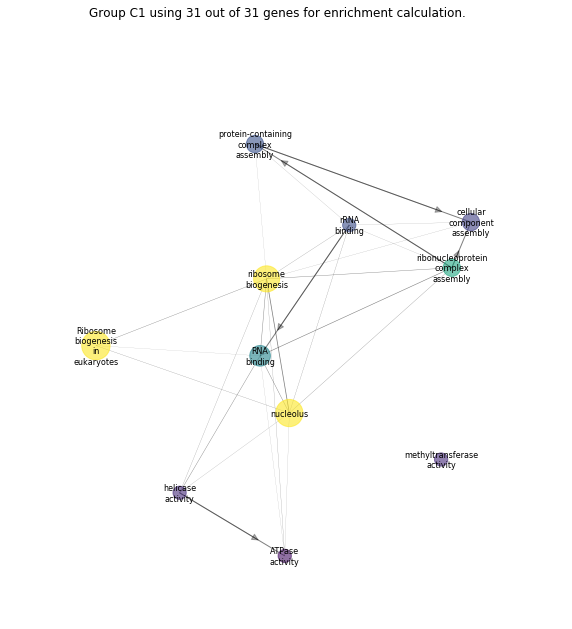

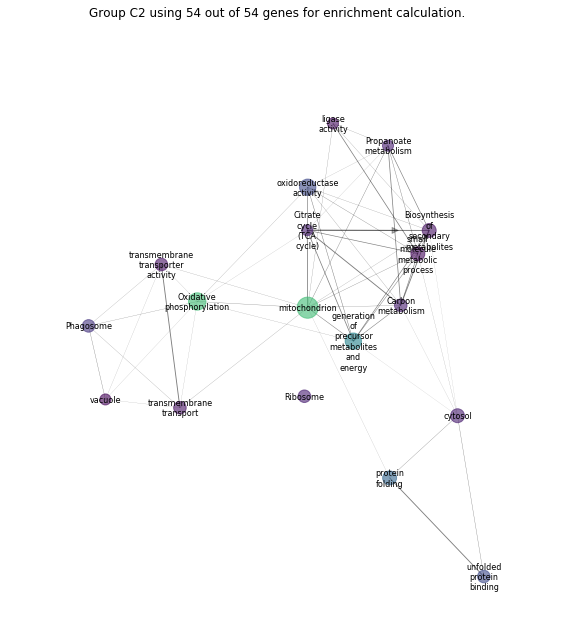

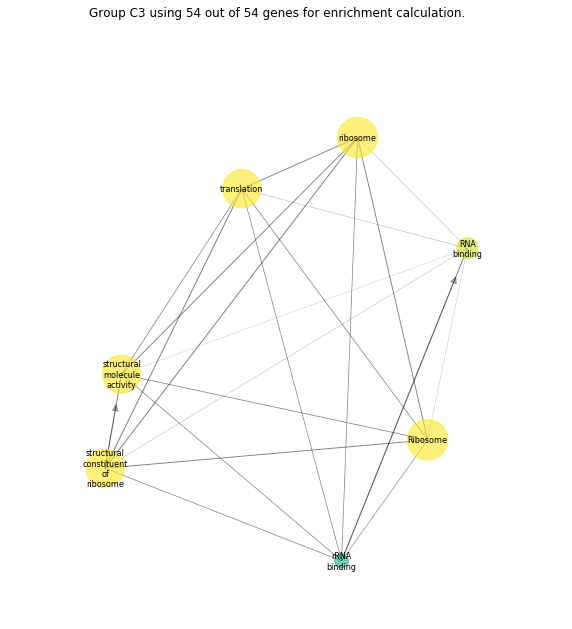

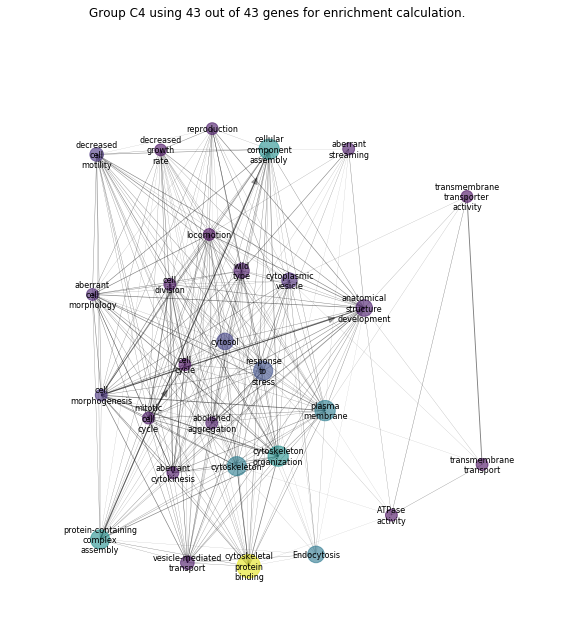

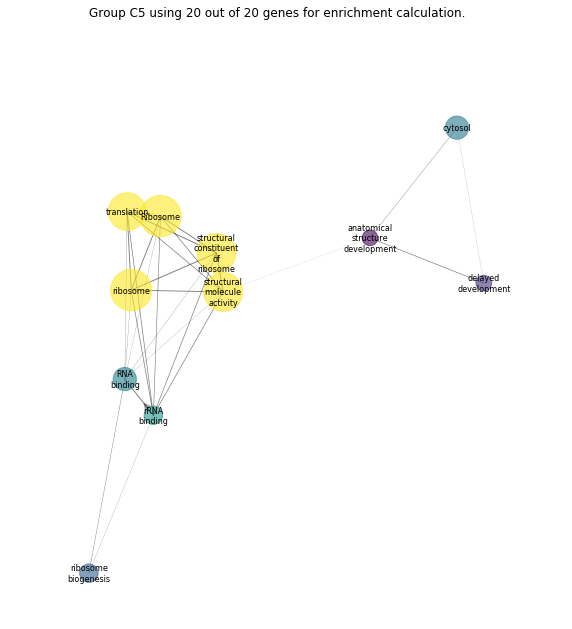

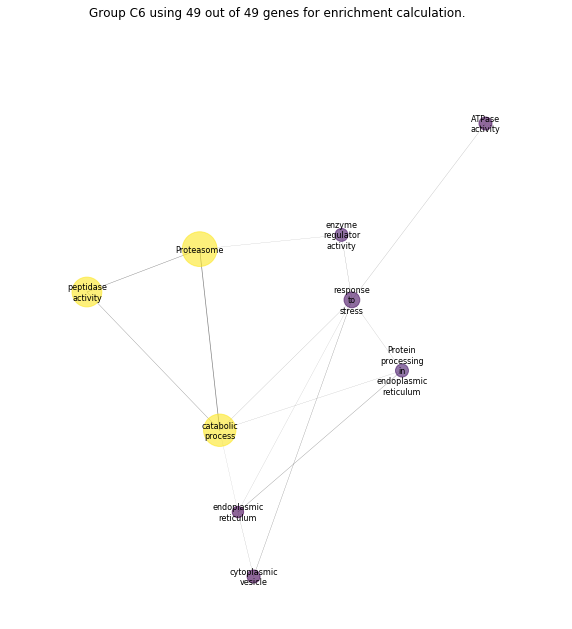

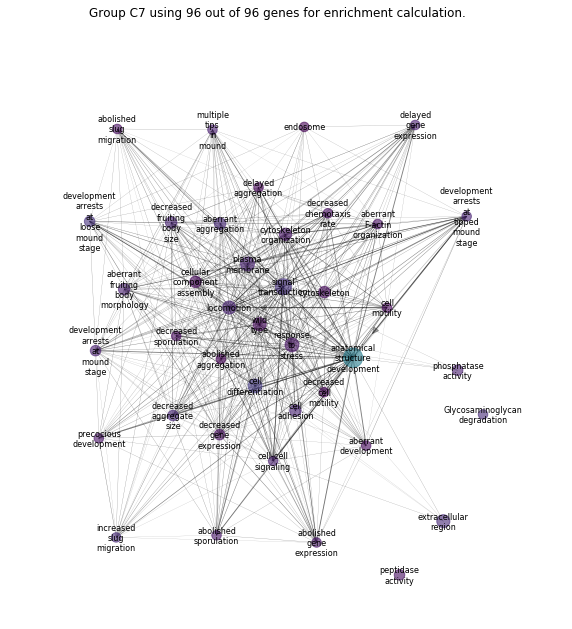

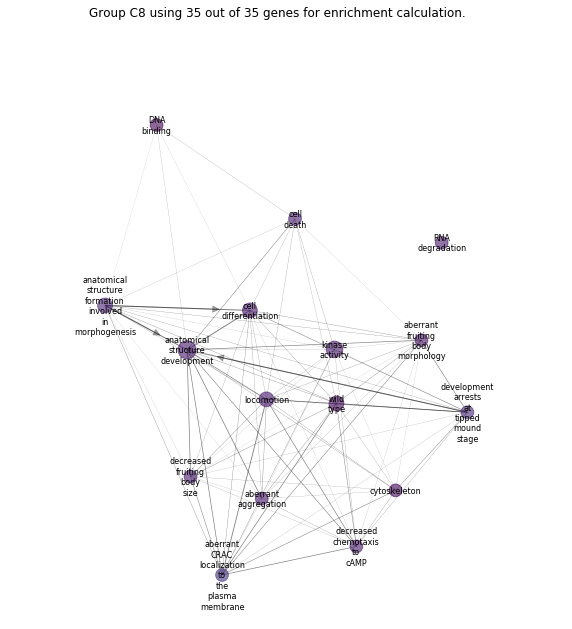

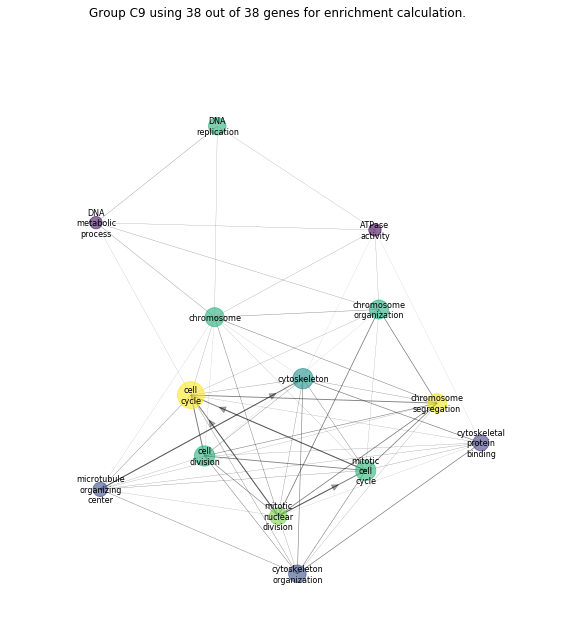

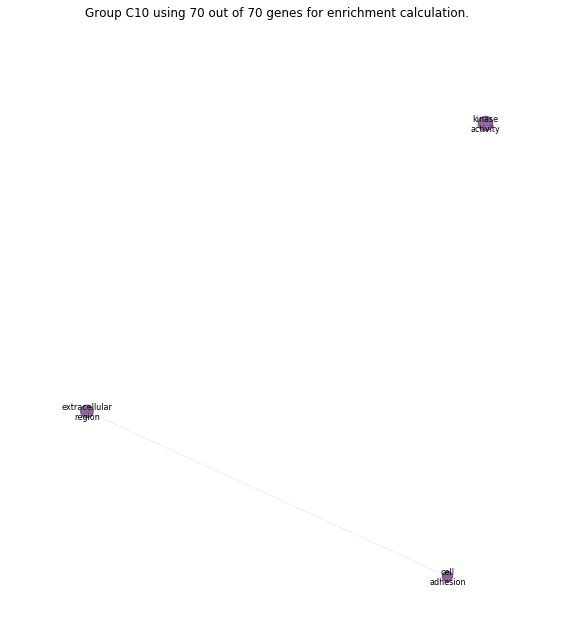

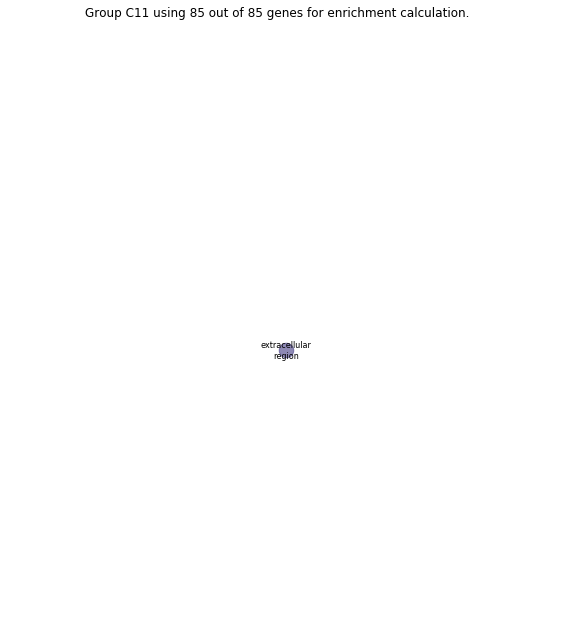

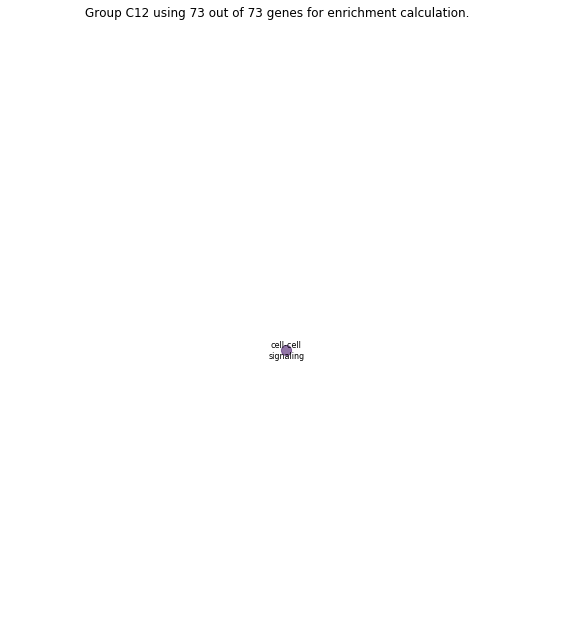

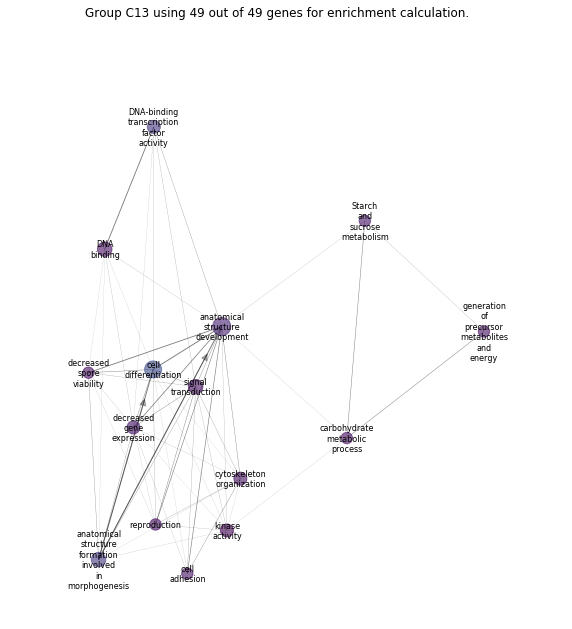

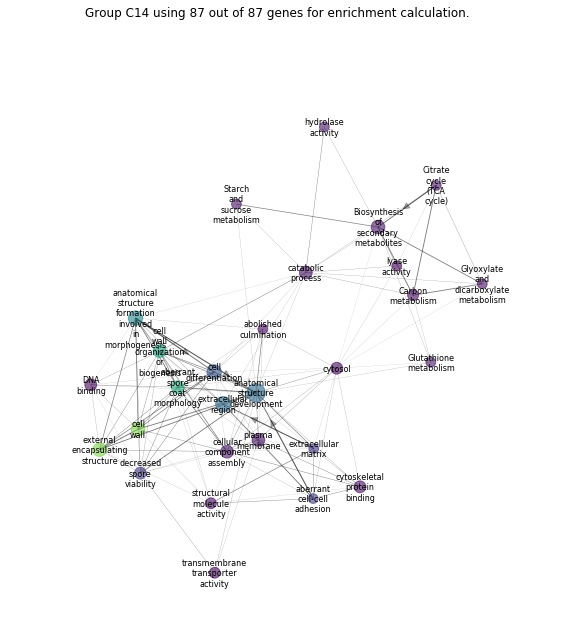

In [10]:
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab',index_col=0)
for group in range(1,len(regulons['Cluster'].unique())+1):
    cluster='C'+str(group)
    print('*** Cluster %s (%s)' %(cluster,string.ascii_uppercase[group-1]))
    enriched=group_diff_enrichment(data=regulons,group=cluster,min_overlap=2)
    if  save_enrichment and enriched is not None:
        enriched.to_csv(pathRegulons+'enrichment/minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log_enrichment_cluster'+str(group)+'.tsv', sep='\t',index=False)

#### Using only genes annotated with at least one gene set

*** Cluster C1 (A)
***  C1 selected: 31 with EID: 31
Ratio of genes annotated with a gene set in reference 0.32 and query 0.71
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 20 out of 22 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Ribosome biogenesis in eukaryotes,KEGG: Pathways,3.11e-15,12,72,68
1,nucleolus,GO: cellular_component,2.24e-13,11,72,72
2,ribosome biogenesis,GO: biological_process,1.48e-12,10,61,61
3,ribonucleoprotein complex assembly,GO: biological_process,1.12e-05,4,18,18
4,RNA binding,GO: molecular_function,1.02e-03,6,169,169
5,rRNA binding,GO: molecular_function,7.87e-03,2,13,13
6,protein-containing complex assembly,GO: biological_process,1.71e-02,4,134,133
7,cellular component assembly,GO: biological_process,6.17e-02,4,202,201
8,helicase activity,GO: molecular_function,7.54e-02,2,51,51
9,methyltransferase activity,GO: molecular_function,8.06e-02,2,58,56




*** Cluster C2 (B)
***  C2 selected: 54 with EID: 54
Ratio of genes annotated with a gene set in reference 0.32 and query 0.57
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 24 out of 31 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Oxidative phosphorylation,KEGG: Pathways,5.95e-06,7,71,54
1,mitochondrion,GO: cellular_component,1.46e-05,11,229,229
2,generation of precursor metabolites and energy,GO: biological_process,3.63e-04,6,77,77
3,protein folding,GO: biological_process,2.05e-03,4,37,37
4,unfolded protein binding,GO: molecular_function,1.08e-02,3,27,27
5,oxidoreductase activity,GO: molecular_function,3.78e-02,6,210,207
6,Phagosome,KEGG: Pathways,5.08e-02,3,53,52
7,Citrate cycle (TCA cycle),KEGG: Pathways,1.34e-01,2,30,30
8,Propanoate metabolism,KEGG: Pathways,1.35e-01,2,32,32
9,Ribosome,KEGG: Pathways,1.87e-01,3,105,97




*** Cluster C3 (C)
***  C3 selected: 54 with EID: 54
Ratio of genes annotated with a gene set in reference 0.32 and query 0.89
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 44 out of 48 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Ribosome,KEGG: Pathways,7.42e-70,44,105,97
1,ribosome,GO: cellular_component,2.13e-68,43,93,93
2,structural constituent of ribosome,GO: molecular_function,4.10e-60,39,85,85
3,structural molecule activity,GO: molecular_function,1.96e-53,39,117,117
4,translation,GO: biological_process,2.62e-46,39,169,169
5,RNA binding,GO: molecular_function,1.27e-05,11,169,169
6,rRNA binding,GO: molecular_function,3.69e-05,4,13,13




*** Cluster C4 (D)
***  C4 selected: 43 with EID: 43
Ratio of genes annotated with a gene set in reference 0.32 and query 0.51
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 20 out of 22 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cytoskeletal protein binding,GO: molecular_function,8.32e-09,11,158,158
1,cellular component assembly,GO: biological_process,9.64e-05,8,202,201
2,cytoskeleton organization,GO: biological_process,9.64e-05,8,197,196
3,protein-containing complex assembly,GO: biological_process,9.64e-05,7,134,133
4,Endocytosis,KEGG: Pathways,4.15e-04,5,77,75
5,cytoskeleton,GO: cellular_component,4.15e-04,7,185,185
6,plasma membrane,GO: cellular_component,4.57e-04,8,268,268
7,response to stress,GO: biological_process,1.72e-02,7,360,358
8,cytosol,GO: cellular_component,2.74e-02,5,203,203
9,cell morphogenesis,GO: biological_process,3.88e-02,2,23,23




*** Cluster C5 (E)
***  C5 selected: 20 with EID: 20
Ratio of genes annotated with a gene set in reference 0.32 and query 0.9
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 18 out of 18 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,ribosome,GO: cellular_component,1.94e-26,17,93,93
1,Ribosome,KEGG: Pathways,2.12e-26,17,105,97
2,structural constituent of ribosome,GO: molecular_function,1.67e-22,15,85,85
3,structural molecule activity,GO: molecular_function,2.14e-20,15,117,117
4,translation,GO: biological_process,5.04e-16,14,169,169
5,rRNA binding,GO: molecular_function,8.23e-05,3,13,13
6,RNA binding,GO: molecular_function,2.36e-03,5,169,169
7,cytosol,GO: cellular_component,4.75e-03,5,203,203
8,ribosome biogenesis,GO: biological_process,6.01e-03,3,61,61
9,delayed development,Dictybase: Phenotypes,8.53e-02,2,69,69




*** Cluster C6 (F)
***  C6 selected: 49 with EID: 49
Ratio of genes annotated with a gene set in reference 0.32 and query 0.94
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 35 out of 46 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,Proteasome,KEGG: Pathways,1.82e-52,29,39,37
1,peptidase activity,GO: molecular_function,4.33e-22,21,91,91
2,catabolic process,GO: biological_process,1.31e-17,25,250,250




*** Cluster C7 (G)
***  C7 selected: 96 with EID: 96
Ratio of genes annotated with a gene set in reference 0.32 and query 0.39
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 30 out of 37 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,anatomical structure development,GO: biological_process,6.54e-05,16,440,438
1,cell differentiation,GO: biological_process,1.77e-02,7,145,145
2,Glycosaminoglycan degradation,KEGG: Pathways,2.73e-02,2,6,6
3,signal transduction,GO: biological_process,2.73e-02,10,352,350
4,development arrests at loose mound stage,Dictybase: Phenotypes,2.73e-02,3,20,20
5,increased slug migration,Dictybase: Phenotypes,3.65e-02,2,8,8
6,aberrant aggregation,Dictybase: Phenotypes,3.65e-02,4,61,61
7,extracellular region,GO: cellular_component,3.79e-02,6,157,157
8,decreased aggregate size,Dictybase: Phenotypes,3.79e-02,3,32,32
9,decreased fruiting body size,Dictybase: Phenotypes,5.27e-02,4,76,75




*** Cluster C8 (H)
***  C8 selected: 35 with EID: 35
Ratio of genes annotated with a gene set in reference 0.32 and query 0.4
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 11 out of 14 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,aberrant CRAC localization to the plasma membrane,Dictybase: Phenotypes,1.47e-02,2,6,6
1,development arrests at tipped mound stage,Dictybase: Phenotypes,3.20e-02,2,12,12
2,anatomical structure formation involved in morphogenesis,GO: biological_process,5.63e-02,3,74,74
3,cell death,GO: biological_process,7.09e-02,2,25,25
4,RNA degradation,KEGG: Pathways,8.09e-02,2,48,48
5,cell differentiation,GO: biological_process,8.09e-02,3,145,145
6,anatomical structure development,GO: biological_process,8.09e-02,5,440,438
7,aberrant aggregation,Dictybase: Phenotypes,8.09e-02,2,61,61
8,decreased chemotaxis to cAMP,Dictybase: Phenotypes,8.09e-02,2,63,63
9,locomotion,GO: biological_process,8.77e-02,3,191,189




*** Cluster C9 (I)
***  C9 selected: 38 with EID: 38
Ratio of genes annotated with a gene set in reference 0.32 and query 0.5
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 18 out of 19 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell cycle,GO: biological_process,6.67e-13,13,167,167
1,chromosome segregation,GO: biological_process,1.58e-09,6,18,18
2,mitotic nuclear division,GO: biological_process,4.78e-08,5,15,15
3,mitotic cell cycle,GO: biological_process,1.81e-06,7,100,100
4,DNA replication,KEGG: Pathways,2.15e-06,5,34,33
5,chromosome,GO: cellular_component,2.74e-06,6,70,70
6,cell division,GO: biological_process,2.74e-06,7,115,115
7,chromosome organization,GO: biological_process,3.35e-06,6,74,74
8,cytoskeleton,GO: cellular_component,5.22e-05,7,185,185
9,microtubule organizing center,GO: cellular_component,5.37e-03,3,50,50




*** Cluster C10 (J)
***  C10 selected: 70 with EID: 70
Ratio of genes annotated with a gene set in reference 0.32 and query 0.26
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 12 out of 18 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,5.80e-02,4,157,157
1,kinase activity,GO: molecular_function,5.80e-02,6,328,327
2,cell adhesion,GO: biological_process,1.74e-01,2,84,83




*** Cluster C11 (K)
***  C11 selected: 85 with EID: 85
Ratio of genes annotated with a gene set in reference 0.32 and query 0.24
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 7 out of 20 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,4.26e-04,7,157,157




*** Cluster C12 (L)
***  C12 selected: 73 with EID: 73
Ratio of genes annotated with a gene set in reference 0.32 and query 0.11
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 5 out of 8 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell-cell signaling,GO: biological_process,6.01e-03,2,16,16
1,anatomical structure development,GO: biological_process,5.17e-02,4,440,438
2,extracellular region,GO: cellular_component,1.33e-01,2,157,157
3,signal transduction,GO: biological_process,2.33e-01,2,352,350
4,wild type,Dictybase: Phenotypes,2.33e-01,2,341,338




*** Cluster C13 (M)
***  C13 selected: 49 with EID: 49
Ratio of genes annotated with a gene set in reference 0.32 and query 0.31
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 13 out of 15 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell differentiation,GO: biological_process,6.40e-04,6,145,145
1,anatomical structure formation involved in morphogenesis,GO: biological_process,5.00e-03,4,74,74
2,DNA-binding transcription factor activity,GO: molecular_function,7.98e-03,3,37,37
3,anatomical structure development,GO: biological_process,1.09e-02,7,440,438
4,decreased gene expression,Dictybase: Phenotypes,5.63e-02,3,95,86
5,Starch and sucrose metabolism,KEGG: Pathways,7.32e-02,2,31,31
6,DNA binding,GO: molecular_function,8.59e-02,4,221,221
7,signal transduction,GO: biological_process,1.04e-01,4,352,350
8,generation of precursor metabolites and energy,GO: biological_process,1.04e-01,2,77,77
9,cytoskeleton organization,GO: biological_process,1.04e-01,3,197,196




*** Cluster C14 (N)
***  C14 selected: 87 with EID: 87
Ratio of genes annotated with a gene set in reference 0.32 and query 0.45
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 33 out of 39 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell wall,GO: cellular_component,4.07e-08,6,13,13
1,external encapsulating structure,GO: cellular_component,4.07e-08,6,13,13
2,aberrant spore coat morphology,Dictybase: Phenotypes,1.45e-06,5,12,12
3,cell wall organization or biogenesis,GO: biological_process,4.02e-06,5,15,15
4,anatomical structure formation involved in morphogenesis,GO: biological_process,9.33e-05,7,74,74
5,extracellular region,GO: cellular_component,1.51e-03,8,157,157
6,anatomical structure development,GO: biological_process,2.03e-03,13,440,438
7,cell differentiation,GO: biological_process,4.48e-03,7,145,145
8,aberrant cell-cell adhesion,Dictybase: Phenotypes,8.16e-03,2,5,5
9,extracellular matrix,GO: cellular_component,1.84e-02,2,8,8




*** Cluster C15 (O)
***  C15 selected: 31 with EID: 31
Ratio of genes annotated with a gene set in reference 0.32 and query 0.26
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 2 out of 8 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,oxidoreductase activity,GO: molecular_function,2.39e-01,2,210,207




*** Cluster C16 (P)
***  C16 selected: 72 with EID: 72
Ratio of genes annotated with a gene set in reference 0.32 and query 0.25
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 12 out of 18 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,6.74e-09,10,157,157
1,wild type,Dictybase: Phenotypes,1.99e-01,5,341,338




*** Cluster C17 (Q)
***  C17 selected: 57 with EID: 56
Ratio of genes annotated with a gene set in reference 0.32 and query 0.2
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 6 out of 11 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell adhesion,GO: biological_process,1.25e-03,4,84,83
1,decreased spore viability,Dictybase: Phenotypes,1.12e-01,2,60,59




*** Cluster C18 (R)
***  C18 selected: 65 with EID: 63
Ratio of genes annotated with a gene set in reference 0.32 and query 0.14
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 8 out of 9 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,cell wall,GO: cellular_component,3.14e-03,2,13,13
1,external encapsulating structure,GO: cellular_component,3.14e-03,2,13,13
2,anatomical structure formation involved in morphogenesis,GO: biological_process,3.14e-03,3,74,74
3,extracellular region,GO: cellular_component,1.39e-02,3,157,157
4,cell differentiation,GO: biological_process,1.39e-02,3,145,145
5,hydrolase activity,GO: molecular_function,1.39e-02,2,46,45
6,lipid binding,GO: molecular_function,2.02e-02,2,59,59
7,anatomical structure development,GO: biological_process,2.88e-02,4,440,438
8,protein transport,GO: biological_process,1.23e-01,2,197,197




*** Cluster C19 (S)
***  C19 selected: 89 with EID: 88
Ratio of genes annotated with a gene set in reference 0.32 and query 0.2
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 10 out of 18 query genes used for enrichment calculation.


,Gene set,Ontology,FDR,N in query,Set size,N in ref.
0,extracellular region,GO: cellular_component,5.93e-05,7,157,157
1,anatomical structure formation involved in morphogenesis,GO: biological_process,2.76e-03,4,74,74
2,cell differentiation,GO: biological_process,2.30e-02,4,145,145
3,Starch and sucrose metabolism,KEGG: Pathways,4.05e-02,2,31,31




*** Cluster C20 (T)
***  C20 selected: 1 with EID: 1
Ratio of genes annotated with a gene set in reference 0.32 and query 0.0
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 0 out of 0 query genes used for enrichment calculation.


None

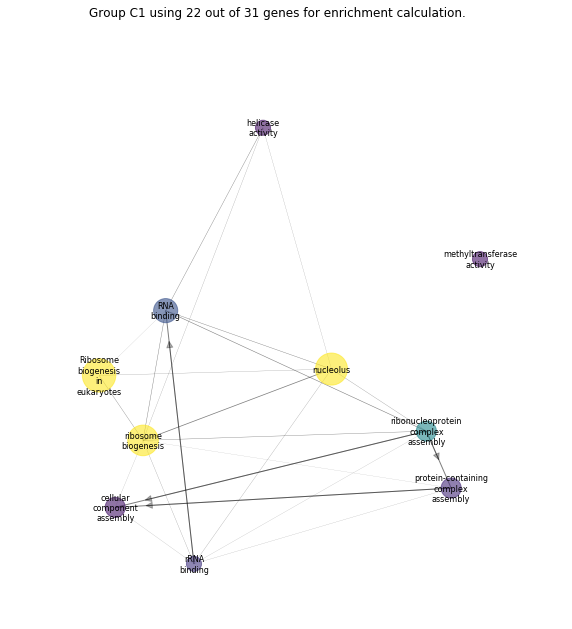

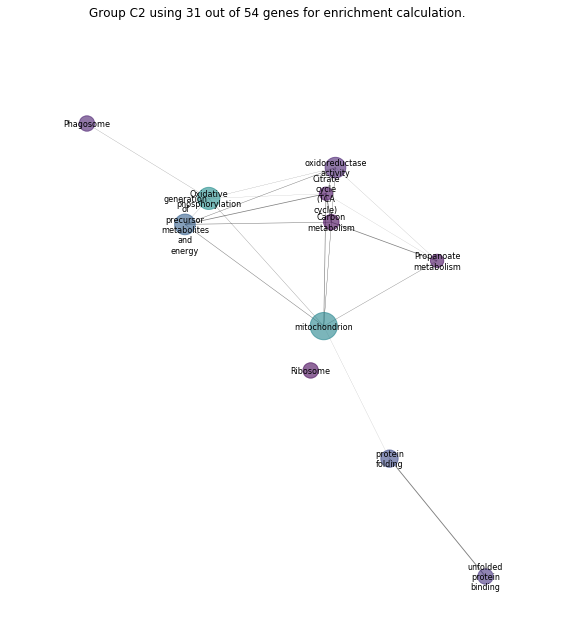

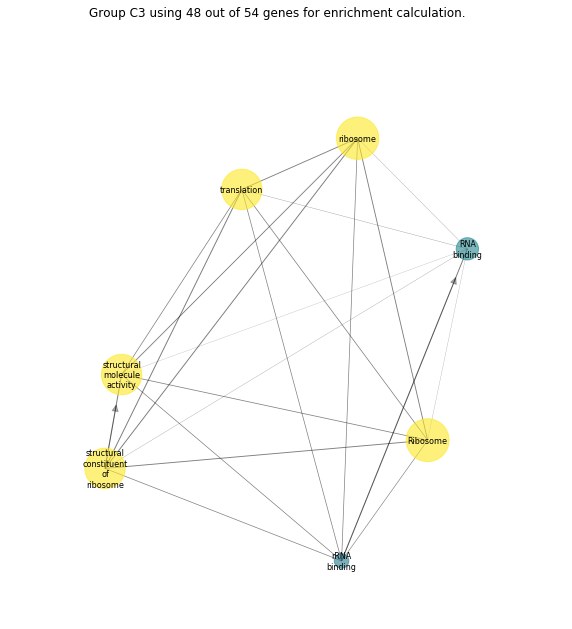

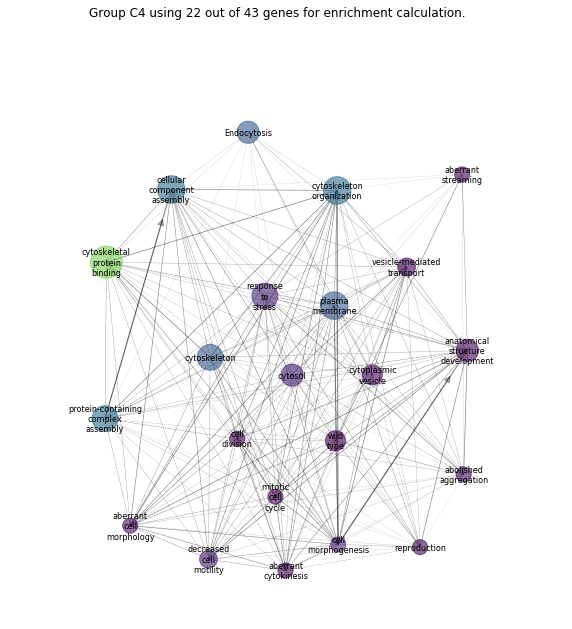

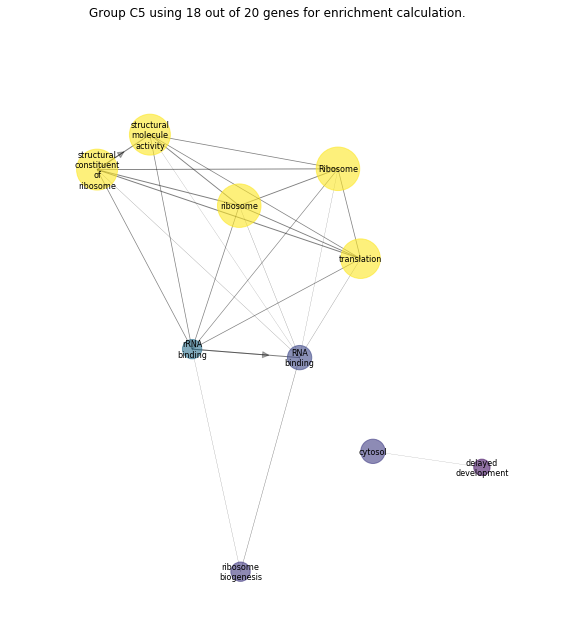

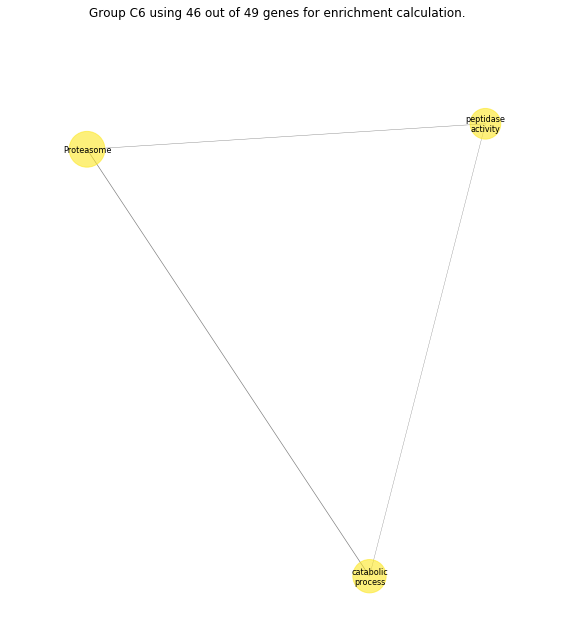

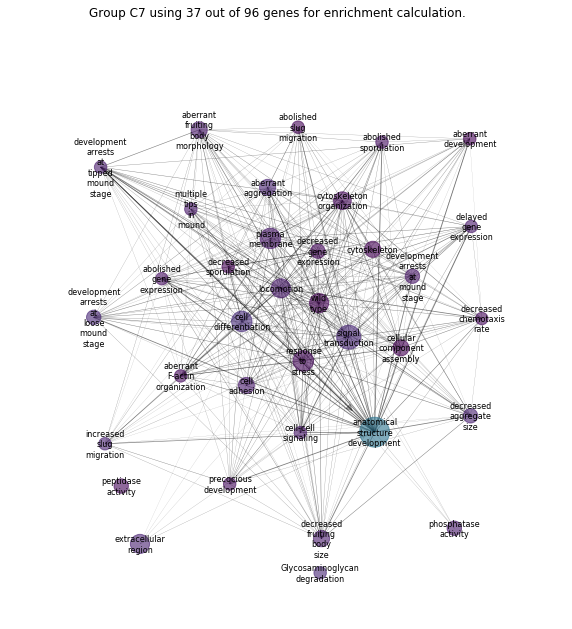

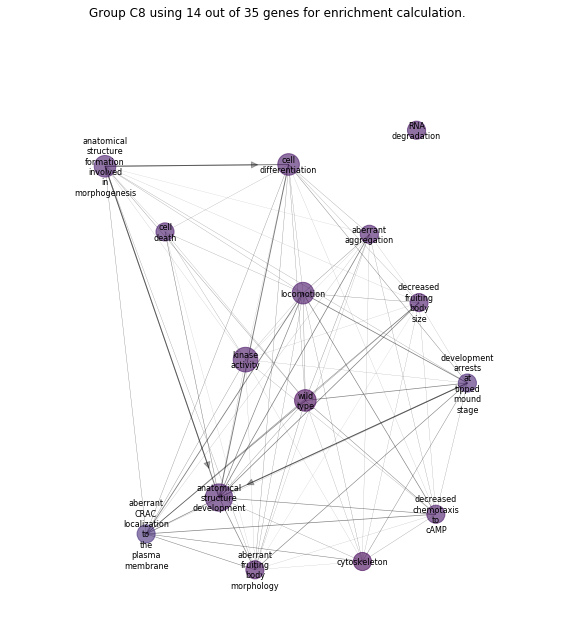

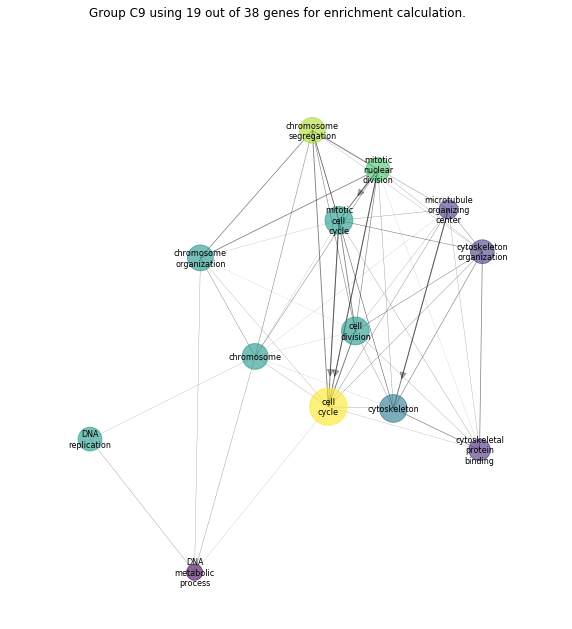

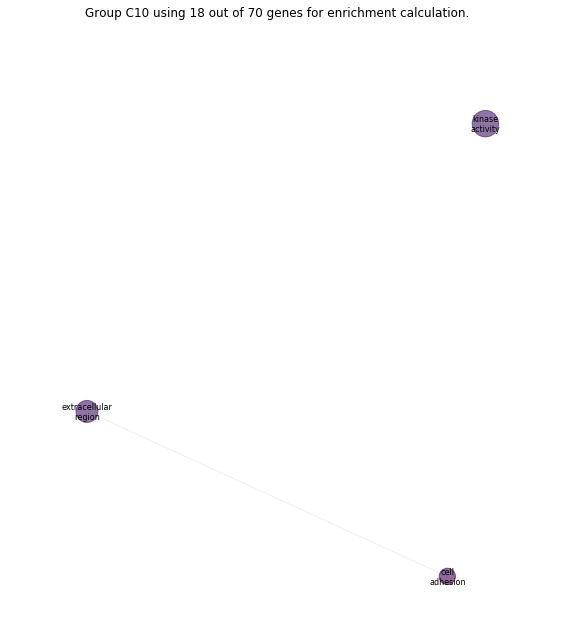

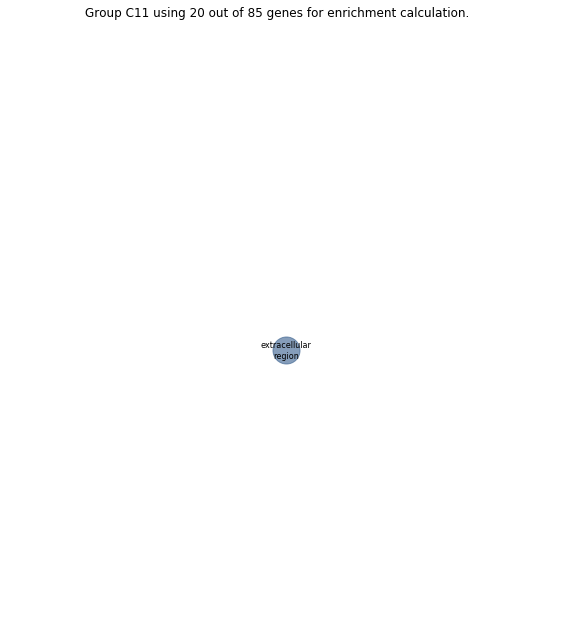

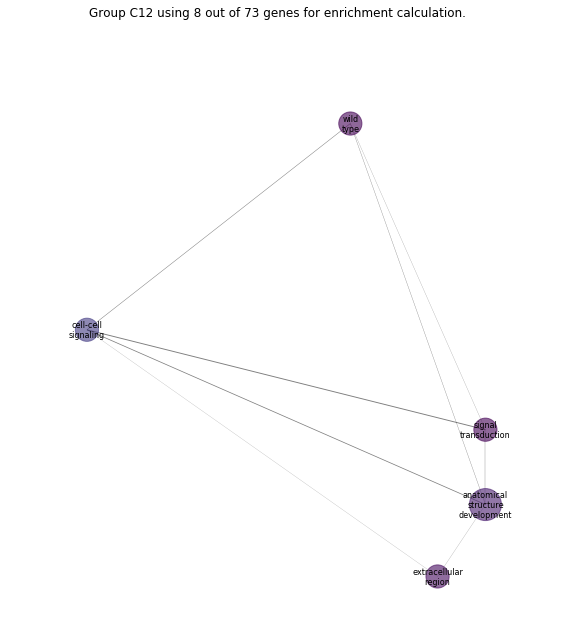

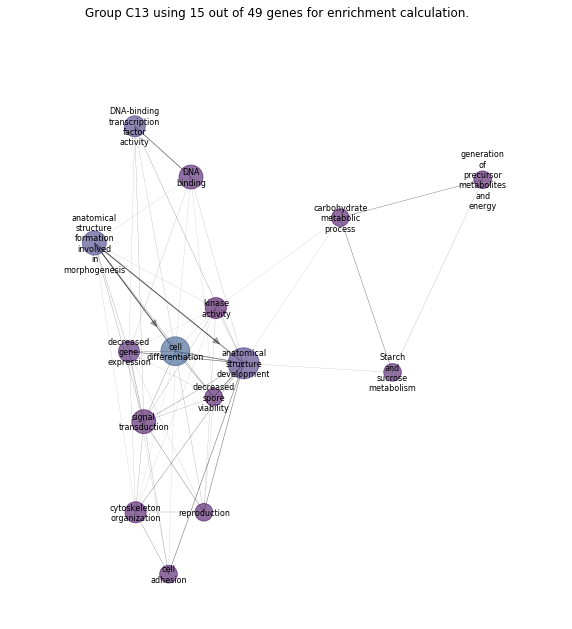

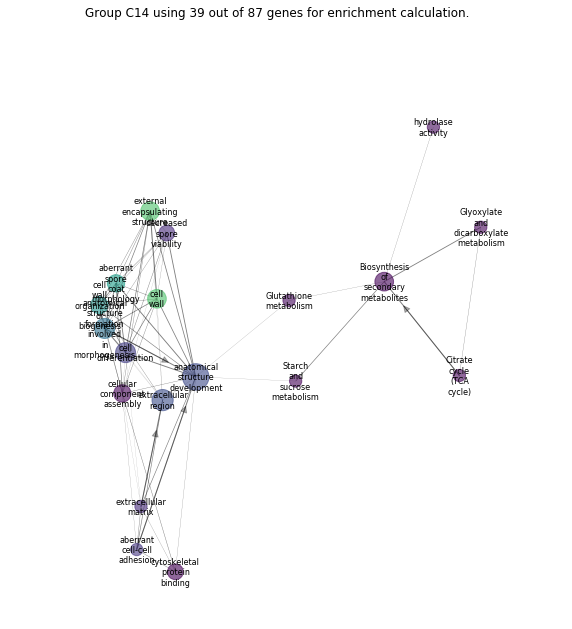

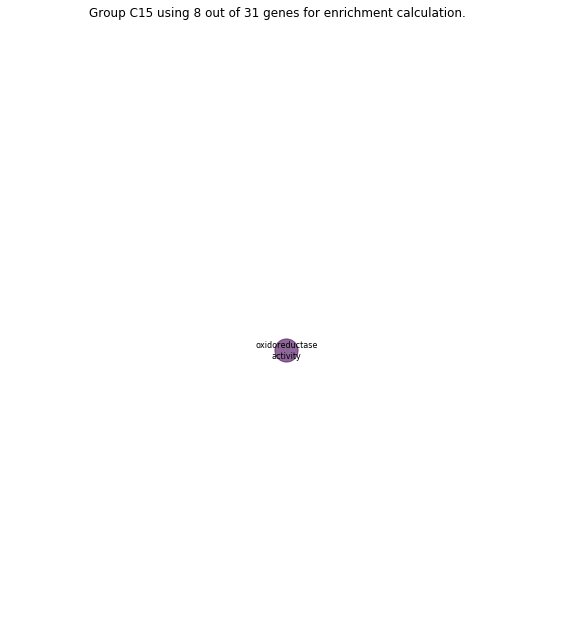

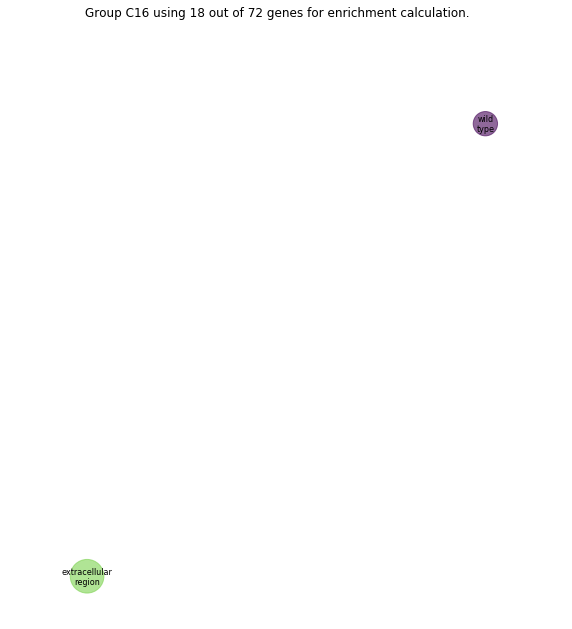

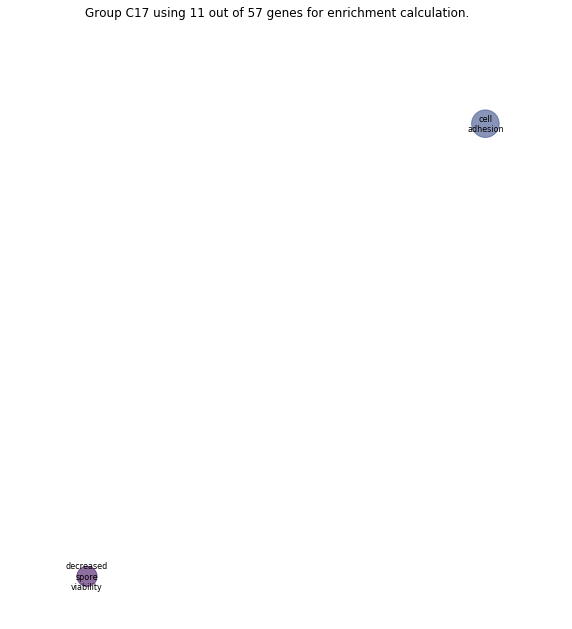

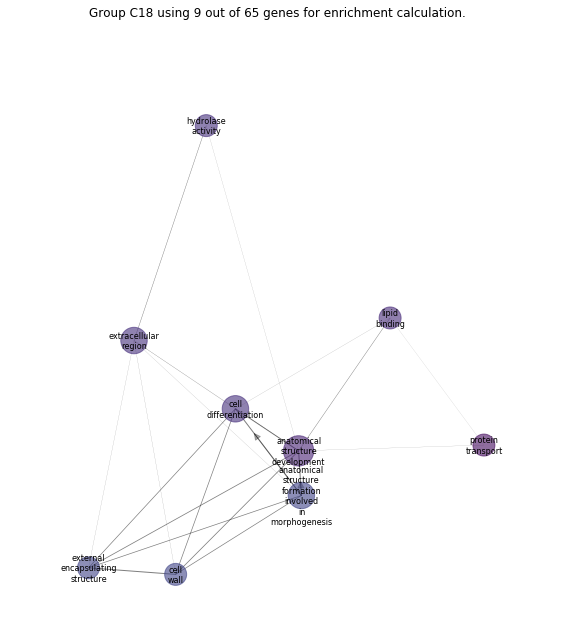

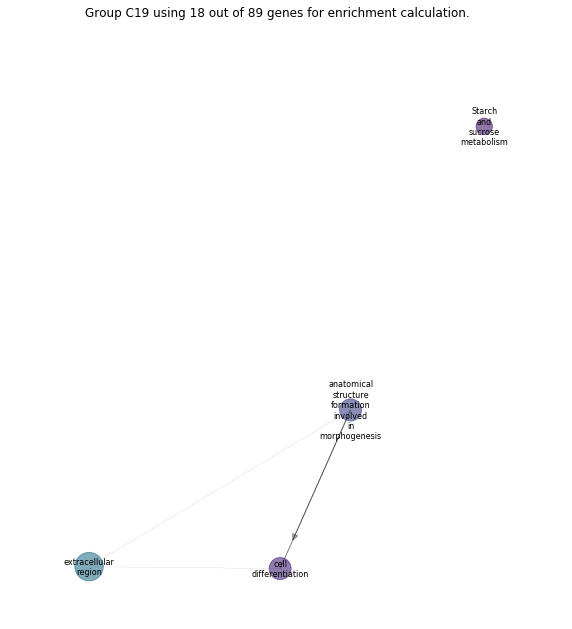

In [19]:
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab',index_col=0)
for group in range(1,len(regulons['Cluster'].unique())+1):
    cluster='C'+str(group)
    print('*** Cluster %s (%s)' %(cluster,string.ascii_uppercase[group-1]))
    enriched=group_diff_enrichment(data=regulons,group=cluster,min_overlap=2,use_annotated_genes=True,enrichment_map=True)
    if save_enrichment and enriched is not None:
        enriched.to_csv(pathRegulons+'enrichment/mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab'+str(group)+'.tsv', sep='\t',index=False)

#### Use all GO gene sets (not only slims), no lower bound on gene set size

In [ ]:
# Get all gene sets
gene_sets=list(list_all(organism='44689'))
GENE_SETS_ONTOLOGY=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=False,set_sizes=(1,500))
# Find out max/min gene set sizes and N sets
max_n=0
min_n=np.inf
for k,v in GENE_SETS_ONTOLOGY.items():
    for s in v:
        n=len(s.genes)
        if n<min_n:
            min_n=n
        if n>max_n:
            max_n=n
print('Min size',min_n,'Max size',max_n)  
print('N sets',{k:len(v) for k,v in GENE_SETS_ONTOLOGY.items()})
regulons=pd.read_table(pathRegulons+'mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab',index_col=0)
for group in range(1,len(regulons['Cluster'].unique())+1):
    cluster='C'+str(group)
    print('*** Cluster %s (%s)' %(cluster,string.ascii_uppercase[group-1]))

    enriched=group_diff_enrichment(data=regulons,group=cluster,min_overlap=2,use_annotated_genes=True)
    if save_enrichment and enriched is not None:
        enriched.to_csv(pathRegulons+'enrichment/mergedGenes_minExpressed0.990.1Strains1Min1Max18_clustersAX4Louvain0.4m0s1log.tab'+str(group)+'.tsv', sep='\t',index=False)